In [1]:
#import packages
import sys
import pandas as pd
import os
import operator
import numpy as np

import catboost as cat
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
# from sklearn.externals import joblib

import time 

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from catboost import CatBoostClassifier, Pool, cv
import catboost.utils
from catboost.utils import get_confusion_matrix

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
channel=pd.read_pickle('customer_service_reps.pickle')
engagement=pd.read_pickle('engagement.pickle')
subs=pd.read_pickle('subscribers2.pickle')
engagement

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
28832315,28409777,2020-04-21,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832317,28409777,2020-04-22,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832319,28409777,2020-04-23,0.0,0.0,4.0,4.0,0.0,1.0,1.0
28832321,28409777,2020-04-24,1.0,0.0,3.0,4.0,1.0,1.0,1.0


In [3]:
channel

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
5,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,1,2019-11-26 03:30:29,2019-12-27 03:30:29,NaN
6,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,2,2019-12-27 03:30:29,2020-01-26 03:30:29,NaN
7,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,3,2020-01-26 03:30:29,NaT,NaN
8,31174901,25914865,True,NaT,2020-03-19 01:20:25,14,True,itunes,1.1377,0,2020-03-19 01:20:25,2020-04-02 01:20:25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248409,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,3,2019-08-27 20:23:27,2019-09-24 20:23:29,NaN
2248410,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,4,2019-09-24 20:23:29,2019-10-25 20:23:28,NaN
2248411,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,5,2019-10-25 20:23:28,2019-11-24 20:23:29,NaN
2248412,30859916,26845271,False,NaT,2019-06-30 06:24:24,0,True,google,0.6239,6,2019-11-24 20:23:29,2019-12-25 20:23:27,NaN


In [4]:
subs['cancel_before_trial_end'].value_counts()

False    124071
True     103557
Name: cancel_before_trial_end, dtype: int64

In [5]:
t=subs['retarget_TF'].value_counts()[0]
f=subs['retarget_TF'].value_counts()[1]
f

7803

In [6]:
use=subs['intended_use'].value_counts()
use

access to exclusive content    89039
replace OTT                    69185
supplement OTT                 26603
expand regional access         14025
expand international access    12978
other                           7112
education                       5137
Name: intended_use, dtype: int64

In [7]:
x=list(use.keys())
x

['access to exclusive content',
 'replace OTT',
 'supplement OTT',
 'expand regional access',
 'expand international access',
 'other',
 'education']

In [8]:
y=use[0:7]

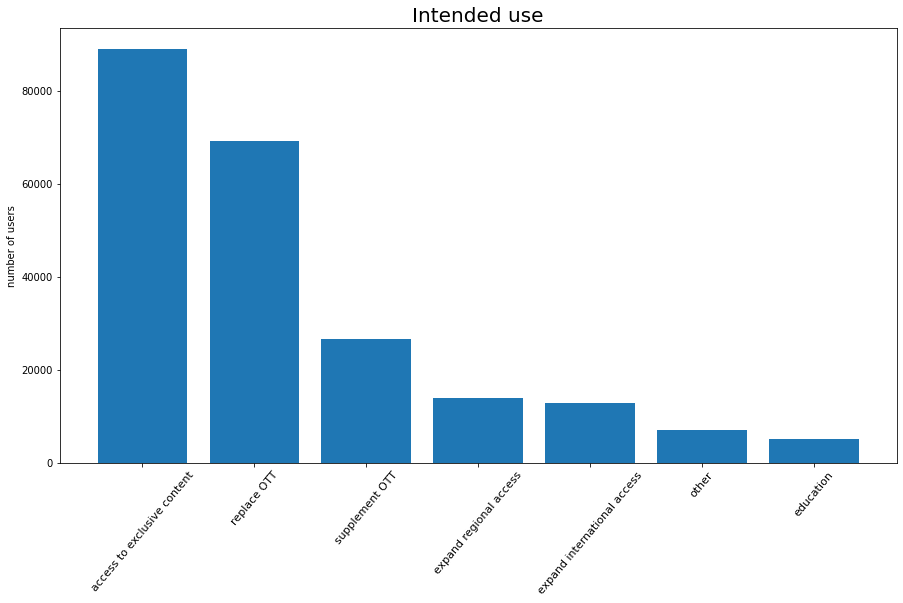

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(15,8))
plt.title('Intended use',fontsize=20)
plt.bar(x,y)
#scale_ls=np.arange(0,7,1)
#index_ls=x[scale_ls]
plt.ylabel('number of users')
plt.xticks(rotation=50,fontsize=11)
plt.show()


In [10]:
engagement

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
28832315,28409777,2020-04-21,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832317,28409777,2020-04-22,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832319,28409777,2020-04-23,0.0,0.0,4.0,4.0,0.0,1.0,1.0
28832321,28409777,2020-04-24,1.0,0.0,3.0,4.0,1.0,1.0,1.0


In [11]:
df1 = engagement.groupby('subid')['date'].apply(list).reset_index(name='dates')


In [12]:
df1=pd.DataFrame(df1)

In [13]:
df1

,subid,dates
0,20000062,"[2019-06-30 00:00:00, 2019-07-01 00:00:00, 201..."
1,20000405,"[2020-03-08 00:00:00, 2020-03-09 00:00:00, 202..."
2,20000604,"[2020-02-09 00:00:00, 2020-02-10 00:00:00, 202..."
3,20000685,"[2020-03-03 00:00:00, 2020-03-04 00:00:00, 202..."
4,20000741,"[2019-08-25 00:00:00, 2019-08-26 00:00:00]"
...,...,...
135014,29999740,"[2019-07-11 00:00:00, 2019-07-13 00:00:00, 201..."
135015,29999820,"[2019-09-22 00:00:00, 2019-09-23 00:00:00, 201..."
135016,29999822,"[2019-11-22 00:00:00, 2019-11-23 00:00:00, 201..."
135017,29999889,"[2019-08-23 00:00:00, 2019-08-24 00:00:00, 201..."


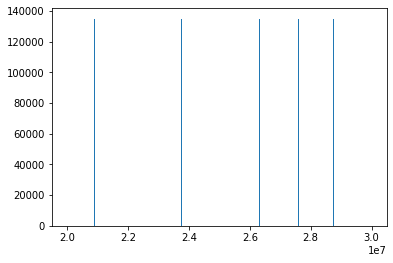

In [14]:
plt.bar(df1['subid'],len(df1['dates']))
plt.show()

In [42]:
df1 = engagement.groupby('date')['app_opens'].apply(list).reset_index(name='app_opens')
df1=pd.DataFrame(df1)
df1['sum apps']=df1['app_opens'].apply(lambda x:sum(x))

df1

,date,app_opens,sum apps
0,2019-06-30,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2274.0
1,2019-07-01,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",4661.0
2,2019-07-02,"[1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6265.0
3,2019-07-03,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7231.0
4,2019-07-04,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...",7908.0
...,...,...,...
296,2020-04-21,"[0.0, 1.0, 2.0, 1.0, 3.0, 1.0, 2.0, 0.0, 2.0, ...",7399.0
297,2020-04-22,"[1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 5.0, 4.0, 1.0, ...",6578.0
298,2020-04-23,"[1.0, 3.0, 1.0, 2.0, 1.0, 4.0, 1.0, 3.0, 1.0, ...",5186.0
299,2020-04-24,"[1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 5.0, 2.0, 3.0, ...",4677.0


In [43]:
df1['sum apps']=df1['app_opens'].apply(lambda x:sum(x))
df1

,date,app_opens,sum apps
0,2019-06-30,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2274.0
1,2019-07-01,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",4661.0
2,2019-07-02,"[1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6265.0
3,2019-07-03,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7231.0
4,2019-07-04,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...",7908.0
...,...,...,...
296,2020-04-21,"[0.0, 1.0, 2.0, 1.0, 3.0, 1.0, 2.0, 0.0, 2.0, ...",7399.0
297,2020-04-22,"[1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 5.0, 4.0, 1.0, ...",6578.0
298,2020-04-23,"[1.0, 3.0, 1.0, 2.0, 1.0, 4.0, 1.0, 3.0, 1.0, ...",5186.0
299,2020-04-24,"[1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 5.0, 2.0, 3.0, ...",4677.0


In [44]:
df1['month'] = pd.to_datetime(df1['date'], format='%Y-%m')
df1

,date,app_opens,sum apps,month
0,2019-06-30,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2274.0,2019-06-30
1,2019-07-01,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",4661.0,2019-07-01
2,2019-07-02,"[1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6265.0,2019-07-02
3,2019-07-03,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7231.0,2019-07-03
4,2019-07-04,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...",7908.0,2019-07-04
...,...,...,...,...
296,2020-04-21,"[0.0, 1.0, 2.0, 1.0, 3.0, 1.0, 2.0, 0.0, 2.0, ...",7399.0,2020-04-21
297,2020-04-22,"[1.0, 2.0, 1.0, 3.0, 1.0, 1.0, 5.0, 4.0, 1.0, ...",6578.0,2020-04-22
298,2020-04-23,"[1.0, 3.0, 1.0, 2.0, 1.0, 4.0, 1.0, 3.0, 1.0, ...",5186.0,2020-04-23
299,2020-04-24,"[1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 5.0, 2.0, 3.0, ...",4677.0,2020-04-24


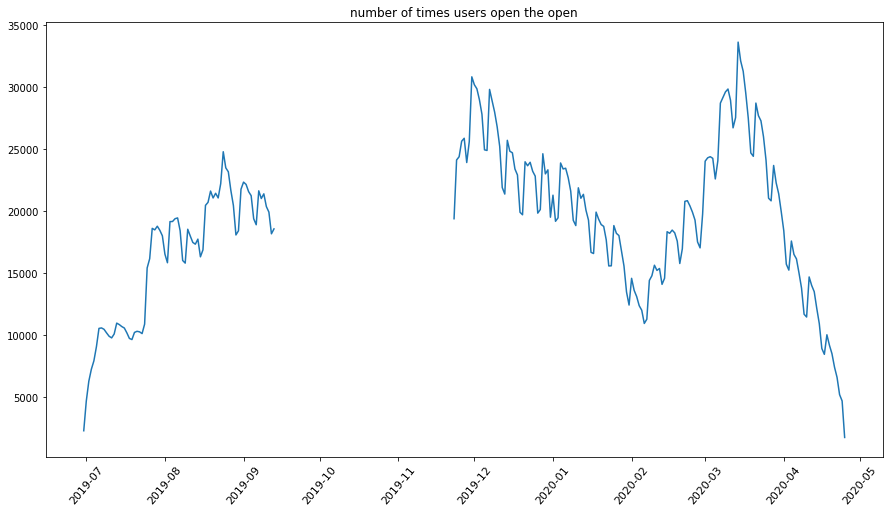

In [45]:
figure(figsize=(15,8))
plt.title('number of times users open the open')
plt.plot(df1['month'],df1['sum apps'])
plt.xticks(rotation=50,fontsize=11)
plt.show()

In [11]:
engagement

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
28832315,28409777,2020-04-21,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832317,28409777,2020-04-22,2.0,0.0,4.0,4.0,0.0,1.0,1.0
28832319,28409777,2020-04-23,0.0,0.0,4.0,4.0,0.0,1.0,1.0
28832321,28409777,2020-04-24,1.0,0.0,3.0,4.0,1.0,1.0,1.0


In [15]:
df = engagement.groupby('subid')['app_opens'].apply(list).reset_index(name='app_opens')
df=pd.DataFrame(df)
df['sum apps']=df['app_opens'].apply(lambda x:sum(x))
df

,subid,app_opens,sum apps
0,20000062,"[1.0, 1.0, 1.0, 1.0]",4.0
1,20000405,"[1.0, 2.0, 2.0, 0.0]",5.0
2,20000604,"[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0
3,20000685,"[2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, ...",46.0
4,20000741,"[1.0, 0.0]",1.0
...,...,...,...
135014,29999740,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0
135015,29999820,"[2.0, 3.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",12.0
135016,29999822,"[1.0, 0.0, 2.0, 1.0, 1.0]",5.0
135017,29999889,"[2.0, 2.0, 4.0, 4.0, 1.0, 4.0, 3.0, 4.0, 2.0, ...",245.0


In [16]:
recency=engagement.groupby('subid')['date'].apply(list).reset_index(name='date')
recency=pd.DataFrame(recency)
recency['last open']=recency['date'].apply(lambda x:x[-1])
recency['total open']=recency['date'].apply(lambda x:len(x))


In [17]:
vid_c=engagement.groupby('subid')['num_videos_completed'].apply(lambda x:sum(x))
vid_c

subid
20000062      6.0
20000405     13.0
20000604      8.0
20000685     14.0
20000741      2.0
            ...  
29999740     11.0
29999820     22.0
29999822      2.0
29999889    326.0
29999945    131.0
Name: num_videos_completed, Length: 135019, dtype: float64

In [18]:
vid_r=engagement.groupby('subid')['num_videos_rated'].apply(lambda x:sum(x))
ser_s=engagement.groupby('subid')['num_series_started'].apply(lambda x:sum(x))
vid_30=engagement.groupby('subid')['num_videos_more_than_30_seconds'].apply(lambda x:sum(x))
vid_comp=engagement.groupby('subid')['num_videos_completed'].apply(lambda x:sum(x))


vid_r

subid
20000062     0.0
20000405     0.0
20000604     0.0
20000685     0.0
20000741     0.0
            ... 
29999740     0.0
29999820     0.0
29999822     0.0
29999889    40.0
29999945     0.0
Name: num_videos_rated, Length: 135019, dtype: float64

In [19]:
df_final=recency.merge(df,left_on='subid',right_on='subid',how='inner')
df_final=df_final.merge(vid_r,left_on='subid',right_on='subid',how='inner')
df_final=df_final.merge(ser_s,left_on='subid',right_on='subid',how='inner')
df_final=df_final.merge(vid_30,left_on='subid',right_on='subid',how='inner')
df_final=df_final.merge(vid_comp,left_on='subid',right_on='subid',how='inner')


df_final

,subid,date,last open,total open,app_opens,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed
0,20000062,"[2019-06-30 00:00:00, 2019-07-01 00:00:00, 201...",2019-07-04,4,"[1.0, 1.0, 1.0, 1.0]",4.0,0.0,1.0,23.0,6.0
1,20000405,"[2020-03-08 00:00:00, 2020-03-09 00:00:00, 202...",2020-03-18,4,"[1.0, 2.0, 2.0, 0.0]",5.0,0.0,1.0,17.0,13.0
2,20000604,"[2020-02-09 00:00:00, 2020-02-10 00:00:00, 202...",2020-03-05,15,"[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,1.0,68.0,8.0
3,20000685,"[2020-03-03 00:00:00, 2020-03-04 00:00:00, 202...",2020-04-15,38,"[2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, ...",46.0,0.0,8.0,165.0,14.0
4,20000741,"[2019-08-25 00:00:00, 2019-08-26 00:00:00]",2019-08-26,2,"[1.0, 0.0]",1.0,0.0,0.0,7.0,2.0
...,...,...,...,...,...,...,...,...,...,...
135014,29999740,"[2019-07-11 00:00:00, 2019-07-13 00:00:00, 201...",2019-07-25,14,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,0.0,31.0,11.0
135015,29999820,"[2019-09-22 00:00:00, 2019-09-23 00:00:00, 201...",2019-10-01,10,"[2.0, 3.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",12.0,0.0,7.0,50.0,22.0
135016,29999822,"[2019-11-22 00:00:00, 2019-11-23 00:00:00, 201...",2019-12-03,5,"[1.0, 0.0, 2.0, 1.0, 1.0]",5.0,0.0,1.0,25.0,2.0
135017,29999889,"[2019-08-23 00:00:00, 2019-08-24 00:00:00, 201...",2019-11-06,76,"[2.0, 2.0, 4.0, 4.0, 1.0, 4.0, 3.0, 4.0, 2.0, ...",245.0,40.0,68.0,326.0,326.0


In [20]:
df_final

# current time reference
cur_time = df_final['last open'].max()
# month diff function
def month_diff(cur_time, datetime_val): 
    return 12 * (cur_time.year - datetime_val.year) + (cur_time.month - datetime_val.month)
# recency month
df_final['recency'] = df_final['last open'].apply(lambda datetime_val: month_diff(cur_time, datetime_val))
df_final

,subid,date,last open,total open,app_opens,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,20000062,"[2019-06-30 00:00:00, 2019-07-01 00:00:00, 201...",2019-07-04,4,"[1.0, 1.0, 1.0, 1.0]",4.0,0.0,1.0,23.0,6.0,9
1,20000405,"[2020-03-08 00:00:00, 2020-03-09 00:00:00, 202...",2020-03-18,4,"[1.0, 2.0, 2.0, 0.0]",5.0,0.0,1.0,17.0,13.0,1
2,20000604,"[2020-02-09 00:00:00, 2020-02-10 00:00:00, 202...",2020-03-05,15,"[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,1.0,68.0,8.0,1
3,20000685,"[2020-03-03 00:00:00, 2020-03-04 00:00:00, 202...",2020-04-15,38,"[2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, ...",46.0,0.0,8.0,165.0,14.0,0
4,20000741,"[2019-08-25 00:00:00, 2019-08-26 00:00:00]",2019-08-26,2,"[1.0, 0.0]",1.0,0.0,0.0,7.0,2.0,8
...,...,...,...,...,...,...,...,...,...,...,...
135014,29999740,"[2019-07-11 00:00:00, 2019-07-13 00:00:00, 201...",2019-07-25,14,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,0.0,31.0,11.0,9
135015,29999820,"[2019-09-22 00:00:00, 2019-09-23 00:00:00, 201...",2019-10-01,10,"[2.0, 3.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",12.0,0.0,7.0,50.0,22.0,6
135016,29999822,"[2019-11-22 00:00:00, 2019-11-23 00:00:00, 201...",2019-12-03,5,"[1.0, 0.0, 2.0, 1.0, 1.0]",5.0,0.0,1.0,25.0,2.0,4
135017,29999889,"[2019-08-23 00:00:00, 2019-08-24 00:00:00, 201...",2019-11-06,76,"[2.0, 2.0, 4.0, 4.0, 1.0, 4.0, 3.0, 4.0, 2.0, ...",245.0,40.0,68.0,326.0,326.0,5


In [21]:
df_final.drop('date',axis=1,inplace=True)
df_final.drop('app_opens',axis=1,inplace=True)
df_final

,subid,last open,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,20000062,2019-07-04,4,4.0,0.0,1.0,23.0,6.0,9
1,20000405,2020-03-18,4,5.0,0.0,1.0,17.0,13.0,1
2,20000604,2020-03-05,15,14.0,0.0,1.0,68.0,8.0,1
3,20000685,2020-04-15,38,46.0,0.0,8.0,165.0,14.0,0
4,20000741,2019-08-26,2,1.0,0.0,0.0,7.0,2.0,8
...,...,...,...,...,...,...,...,...,...
135014,29999740,2019-07-25,14,15.0,0.0,0.0,31.0,11.0,9
135015,29999820,2019-10-01,10,12.0,0.0,7.0,50.0,22.0,6
135016,29999822,2019-12-03,5,5.0,0.0,1.0,25.0,2.0,4
135017,29999889,2019-11-06,76,245.0,40.0,68.0,326.0,326.0,5


In [22]:
df_final

,subid,last open,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,20000062,2019-07-04,4,4.0,0.0,1.0,23.0,6.0,9
1,20000405,2020-03-18,4,5.0,0.0,1.0,17.0,13.0,1
2,20000604,2020-03-05,15,14.0,0.0,1.0,68.0,8.0,1
3,20000685,2020-04-15,38,46.0,0.0,8.0,165.0,14.0,0
4,20000741,2019-08-26,2,1.0,0.0,0.0,7.0,2.0,8
...,...,...,...,...,...,...,...,...,...
135014,29999740,2019-07-25,14,15.0,0.0,0.0,31.0,11.0,9
135015,29999820,2019-10-01,10,12.0,0.0,7.0,50.0,22.0,6
135016,29999822,2019-12-03,5,5.0,0.0,1.0,25.0,2.0,4
135017,29999889,2019-11-06,76,245.0,40.0,68.0,326.0,326.0,5


In [23]:
#colskeep=['subid','package_type','preferred_genre','intended_use','weekly_consumption_hour',
 #        'age','num_ideal_streaming_services','revenue_net','join_fee']
colskeep=['subid','package_type','preferred_genre','intended_use','weekly_consumption_hour',
         'age','revenue_net']
subs2=subs[colskeep]
subs2

,subid,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,revenue_net
162502,21724479,economy,comedy,access to exclusive content,NaN,NaN,NaN
380374,23383224,base,comedy,access to exclusive content,22.951579,70.0,0.0000
496617,26844789,enhanced,regional,replace OTT,36.001186,25.0,0.0000
356799,29417030,base,drama,replace OTT,20.051667,30.0,0.0000
681701,26723159,base,comedy,replace OTT,22.951579,28.0,0.0000
...,...,...,...,...,...,...,...
509326,21434712,enhanced,comedy,supplement OTT,28.751405,38.0,0.0000
229587,25843074,enhanced,comedy,replace OTT,27.301448,49.0,4.5875
281340,24799085,base,comedy,access to exclusive content,31.651317,45.0,0.0000
87198,21308040,base,comedy,access to exclusive content,NaN,NaN,NaN


In [24]:
#df_final2=df_final.merge(subs2,left_on='subid',right_on='subid',how='inner')
#df_final2=subs2
df_final2=df_final
df_final2

,subid,last open,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,20000062,2019-07-04,4,4.0,0.0,1.0,23.0,6.0,9
1,20000405,2020-03-18,4,5.0,0.0,1.0,17.0,13.0,1
2,20000604,2020-03-05,15,14.0,0.0,1.0,68.0,8.0,1
3,20000685,2020-04-15,38,46.0,0.0,8.0,165.0,14.0,0
4,20000741,2019-08-26,2,1.0,0.0,0.0,7.0,2.0,8
...,...,...,...,...,...,...,...,...,...
135014,29999740,2019-07-25,14,15.0,0.0,0.0,31.0,11.0,9
135015,29999820,2019-10-01,10,12.0,0.0,7.0,50.0,22.0,6
135016,29999822,2019-12-03,5,5.0,0.0,1.0,25.0,2.0,4
135017,29999889,2019-11-06,76,245.0,40.0,68.0,326.0,326.0,5


In [25]:
df_final2=pd.get_dummies(df_final2)
df_final2

,subid,last open,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,20000062,2019-07-04,4,4.0,0.0,1.0,23.0,6.0,9
1,20000405,2020-03-18,4,5.0,0.0,1.0,17.0,13.0,1
2,20000604,2020-03-05,15,14.0,0.0,1.0,68.0,8.0,1
3,20000685,2020-04-15,38,46.0,0.0,8.0,165.0,14.0,0
4,20000741,2019-08-26,2,1.0,0.0,0.0,7.0,2.0,8
...,...,...,...,...,...,...,...,...,...
135014,29999740,2019-07-25,14,15.0,0.0,0.0,31.0,11.0,9
135015,29999820,2019-10-01,10,12.0,0.0,7.0,50.0,22.0,6
135016,29999822,2019-12-03,5,5.0,0.0,1.0,25.0,2.0,4
135017,29999889,2019-11-06,76,245.0,40.0,68.0,326.0,326.0,5


In [26]:

from sklearn.model_selection import train_test_split as tts

x=df_final2.drop('subid',axis=1)
x=x.drop('last open',axis=1)
train_set,test_set=tts(x,test_size=0.4,random_state=88, shuffle=True)
from sklearn.preprocessing import StandardScaler as st
xt_normalized=st().fit(train_set).transform(train_set)
xc_train=pd.DataFrame(xt_normalized)
xc_train.columns=x.columns

xc_train




,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,-0.564791,-0.350992,-0.253921,-0.527413,-0.489681,-0.408899,-0.109519
1,-0.472057,-0.469078,-0.253921,-0.472275,-0.512483,-0.422790,0.244975
2,0.501652,-0.219786,-0.253921,0.299647,0.650436,-0.520025,-0.818507
3,1.243525,1.013555,-0.253921,0.685609,1.391512,0.466215,-0.464013
4,-0.657525,-0.495319,-0.253921,-0.692825,-0.683501,-0.714495,-1.173001
...,...,...,...,...,...,...,...
81006,-0.750260,-0.495319,-0.253921,-0.692825,-0.717705,-0.686713,0.953962
81007,-0.796627,-0.534681,-0.253921,-0.692825,-0.843117,-0.686713,1.662950
81008,-0.286589,-0.311630,-0.253921,-0.527413,-0.432675,-0.603369,-1.173001
81009,-0.750260,-0.508440,-0.253921,-0.692825,-0.729106,-0.603369,1.662950


In [27]:
xtest_normalized=st().fit(train_set).transform(test_set)
xct=pd.DataFrame(xtest_normalized)
xct.columns=x.columns

xct


,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,-0.842994,-0.547802,-0.253921,-0.637687,-0.922926,-0.714495,1.308456
1,-0.425690,-0.364113,-0.253921,-0.306863,-0.387071,-0.228320,1.662950
2,-0.611158,-0.377233,-0.253921,-0.582550,-0.603693,-0.533915,0.599468
3,1.243525,4.110027,-0.253921,1.622943,1.425716,1.771942,-0.818507
4,-0.611158,-0.495319,-0.253921,-0.692825,-0.626495,-0.686713,-1.173001
...,...,...,...,...,...,...,...
54003,1.150791,1.000434,2.113789,1.567806,1.288902,0.924609,-0.818507
54004,2.031766,0.698659,-0.253921,0.520197,1.608134,-0.478353,0.953962
54005,-0.842994,-0.547802,-0.253921,-0.692825,-0.922926,-0.714495,0.244975
54006,0.501652,0.331281,-0.017150,0.740746,0.684640,0.785702,-1.527495


In [28]:
x=df_final2.drop('subid',axis=1)
x=x.drop('last open',axis=1)
from sklearn.preprocessing import StandardScaler as st
x_normalized=st().fit(x).transform(x)
xc=pd.DataFrame(x_normalized)
xc

,0,1,2,3,4,5,6
0,-0.703572,-0.501203,-0.252438,-0.638028,-0.661014,-0.631799,1.663801
1,-0.703572,-0.487787,-0.252438,-0.638028,-0.729711,-0.533970,-1.174549
2,-0.192755,-0.367042,-0.252438,-0.638028,-0.145786,-0.603848,-1.174549
3,0.875317,0.062273,-0.252438,-0.250006,0.964817,-0.519994,-1.529343
4,-0.796448,-0.541451,-0.252438,-0.693459,-0.844206,-0.687702,1.309007
...,...,...,...,...,...,...,...
135014,-0.239193,-0.353626,-0.252438,-0.693459,-0.569418,-0.561921,1.663801
135015,-0.424945,-0.393874,-0.252438,-0.305438,-0.351877,-0.408189,0.599420
135016,-0.657134,-0.487787,-0.252438,-0.638028,-0.638115,-0.687702,-0.110168
135017,2.639957,2.732077,9.340319,3.075895,2.808189,3.840400,0.244626


In [29]:
x.columns

Index(['total open', 'sum apps', 'num_videos_rated', 'num_series_started',
       'num_videos_more_than_30_seconds', 'num_videos_completed', 'recency'],
      dtype='object')

In [30]:
xc.columns=x.columns
xc

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,-0.703572,-0.501203,-0.252438,-0.638028,-0.661014,-0.631799,1.663801
1,-0.703572,-0.487787,-0.252438,-0.638028,-0.729711,-0.533970,-1.174549
2,-0.192755,-0.367042,-0.252438,-0.638028,-0.145786,-0.603848,-1.174549
3,0.875317,0.062273,-0.252438,-0.250006,0.964817,-0.519994,-1.529343
4,-0.796448,-0.541451,-0.252438,-0.693459,-0.844206,-0.687702,1.309007
...,...,...,...,...,...,...,...
135014,-0.239193,-0.353626,-0.252438,-0.693459,-0.569418,-0.561921,1.663801
135015,-0.424945,-0.393874,-0.252438,-0.305438,-0.351877,-0.408189,0.599420
135016,-0.657134,-0.487787,-0.252438,-0.638028,-0.638115,-0.687702,-0.110168
135017,2.639957,2.732077,9.340319,3.075895,2.808189,3.840400,0.244626


In [31]:
xc.isnull().sum()
#fill na
xc.fillna(xc.mean(),inplace=True)
xc

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,-0.703572,-0.501203,-0.252438,-0.638028,-0.661014,-0.631799,1.663801
1,-0.703572,-0.487787,-0.252438,-0.638028,-0.729711,-0.533970,-1.174549
2,-0.192755,-0.367042,-0.252438,-0.638028,-0.145786,-0.603848,-1.174549
3,0.875317,0.062273,-0.252438,-0.250006,0.964817,-0.519994,-1.529343
4,-0.796448,-0.541451,-0.252438,-0.693459,-0.844206,-0.687702,1.309007
...,...,...,...,...,...,...,...
135014,-0.239193,-0.353626,-0.252438,-0.693459,-0.569418,-0.561921,1.663801
135015,-0.424945,-0.393874,-0.252438,-0.305438,-0.351877,-0.408189,0.599420
135016,-0.657134,-0.487787,-0.252438,-0.638028,-0.638115,-0.687702,-0.110168
135017,2.639957,2.732077,9.340319,3.075895,2.808189,3.840400,0.244626


In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(xc)
x_pca

array([[-1.56378439,  1.52855391],
       [-1.29759058, -1.26062729],
       [-0.80216851, -1.23634931],
       ...,
       [-1.39763513, -0.21706729],
       [ 8.98520065,  2.01785551],
       [ 1.68645249, -1.41088955]])

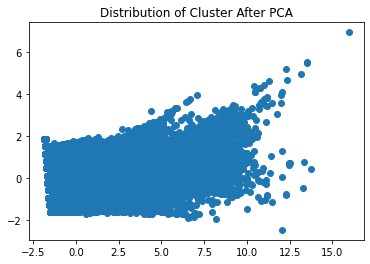

In [33]:
x_pca=pd.DataFrame(x_pca)

plt.title('Distribution of Cluster After PCA')
plt.scatter(x_pca[0], x_pca[1])
plt.show()

In [34]:
xct

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency
0,-0.842994,-0.547802,-0.253921,-0.637687,-0.922926,-0.714495,1.308456
1,-0.425690,-0.364113,-0.253921,-0.306863,-0.387071,-0.228320,1.662950
2,-0.611158,-0.377233,-0.253921,-0.582550,-0.603693,-0.533915,0.599468
3,1.243525,4.110027,-0.253921,1.622943,1.425716,1.771942,-0.818507
4,-0.611158,-0.495319,-0.253921,-0.692825,-0.626495,-0.686713,-1.173001
...,...,...,...,...,...,...,...
54003,1.150791,1.000434,2.113789,1.567806,1.288902,0.924609,-0.818507
54004,2.031766,0.698659,-0.253921,0.520197,1.608134,-0.478353,0.953962
54005,-0.842994,-0.547802,-0.253921,-0.692825,-0.922926,-0.714495,0.244975
54006,0.501652,0.331281,-0.017150,0.740746,0.684640,0.785702,-1.527495


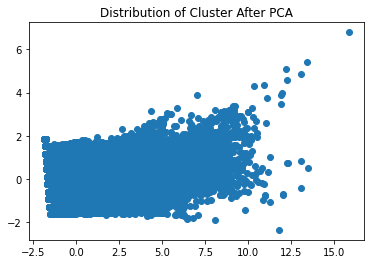

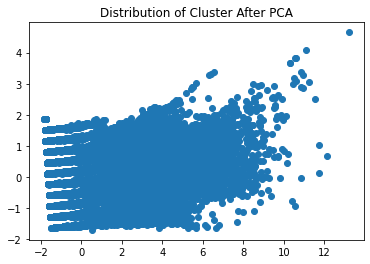

In [35]:
xc_train.fillna(xc_train.mean(),inplace=True)
xct.fillna(xc_train.mean(),inplace=True)

xtrain_pca=pca.fit_transform(xc_train)
xtrain_pca=pd.DataFrame(xtrain_pca)
xtrain_pca
plt.title('Distribution of Cluster After PCA')
plt.scatter(xtrain_pca[0], xtrain_pca[1])
plt.show()

xt_pca=pca.fit_transform(xct)
xt_pca=pd.DataFrame(xt_pca)


plt.title('Distribution of Cluster After PCA')
plt.scatter(xt_pca[0], xt_pca[1])
plt.show()


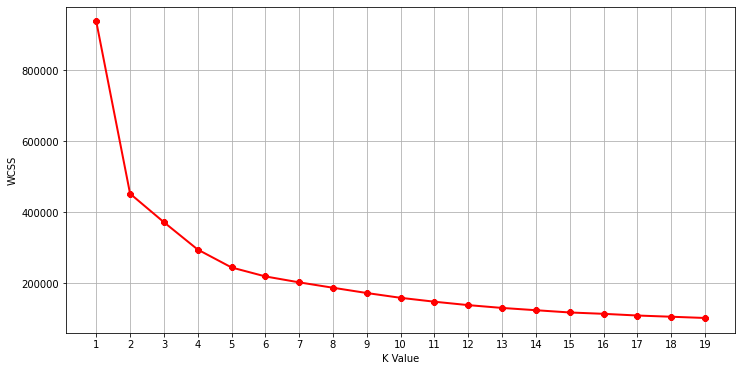

In [182]:

from sklearn.cluster import KMeans
wcss = []
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    clust=kmeans.fit_predict(xc)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,20),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,20,1))
plt.ylabel("WCSS")
plt.show()

In [36]:
# k means
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0)
clust=kmeans.fit_predict(xc)
#silhouette_avg = silhouette_score(xc, clust)
#print('score for train_set:',silhouette_avg)
xc['cluster']=clust

# get centroids
centroids = kmeans.cluster_centers_
#score for train: 0.4390529467222094
df_final2['cluster']=clust
df_final2

,subid,last open,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster
0,20000062,2019-07-04,4,4.0,0.0,1.0,23.0,6.0,9,2
1,20000405,2020-03-18,4,5.0,0.0,1.0,17.0,13.0,1,0
2,20000604,2020-03-05,15,14.0,0.0,1.0,68.0,8.0,1,0
3,20000685,2020-04-15,38,46.0,0.0,8.0,165.0,14.0,0,0
4,20000741,2019-08-26,2,1.0,0.0,0.0,7.0,2.0,8,2
...,...,...,...,...,...,...,...,...,...,...
135014,29999740,2019-07-25,14,15.0,0.0,0.0,31.0,11.0,9,2
135015,29999820,2019-10-01,10,12.0,0.0,7.0,50.0,22.0,6,2
135016,29999822,2019-12-03,5,5.0,0.0,1.0,25.0,2.0,4,0
135017,29999889,2019-11-06,76,245.0,40.0,68.0,326.0,326.0,5,1


In [37]:
df_final['last open'].min()

Timestamp('2019-06-30 00:00:00')

In [38]:
clust_train=kmeans.fit_predict(xc_train)
clust_test=kmeans.predict(xct)
#silhouette_avg = silhouette_score(xc, clust)
#print('score for train_set:',silhouette_avg)


In [788]:
silhouette_avg = silhouette_score(xc, clust)
silhouette_avg_train = silhouette_score(xc_train, clust_train)
silhouette_avg_test = silhouette_score(xct, clust_test)


print('score for train_set:',silhouette_avg)
#0.25

NameError: name 'silhouette_avg' is not defined

In [793]:
print('score for train_set:',silhouette_avg_train,'\nscore for test_set:',silhouette_avg_test)
#conclusion: result is stable

score for train_set: 0.4130215211509411 
score for test_set: 0.4109363558693883


In [39]:
#pca = PCA(n_components=2)
#x_pca = pca.fit_transform(xc)
xc['cluster']=clust
xc_train['cluster']=clust_train
xct['cluster']=clust_test

xc_train

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster
0,-0.564791,-0.350992,-0.253921,-0.527413,-0.489681,-0.408899,-0.109519,0
1,-0.472057,-0.469078,-0.253921,-0.472275,-0.512483,-0.422790,0.244975,3
2,0.501652,-0.219786,-0.253921,0.299647,0.650436,-0.520025,-0.818507,0
3,1.243525,1.013555,-0.253921,0.685609,1.391512,0.466215,-0.464013,2
4,-0.657525,-0.495319,-0.253921,-0.692825,-0.683501,-0.714495,-1.173001,0
...,...,...,...,...,...,...,...,...
81006,-0.750260,-0.495319,-0.253921,-0.692825,-0.717705,-0.686713,0.953962,3
81007,-0.796627,-0.534681,-0.253921,-0.692825,-0.843117,-0.686713,1.662950,3
81008,-0.286589,-0.311630,-0.253921,-0.527413,-0.432675,-0.603369,-1.173001,0
81009,-0.750260,-0.508440,-0.253921,-0.692825,-0.729106,-0.603369,1.662950,3


In [40]:
x['cluster']=clust
train_set['cluster']=clust_train
test_set['cluster']=clust_test

In [41]:
cen_x = [i[0] for i in centroids] 
cen_x

[-0.5110471908826407,
 2.0677111224284066,
 -0.5306460056198676,
 1.325424106754248]

In [42]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
list(colors.values())[0:12]

[(0, 0, 1),
 (0, 0.5, 0),
 (1, 0, 0),
 (0, 0.75, 0.75),
 (0.75, 0, 0.75),
 (0.75, 0.75, 0),
 (0, 0, 0),
 (1, 1, 1),
 '#F0F8FF',
 '#FAEBD7',
 '#00FFFF',
 '#7FFFD4']

In [43]:
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
dic={}
d={}
d2={}
for i in range(0,4):
    d[i]=cen_x[i]
    d2[i]=cen_y[i]

xc['cen_x']=xc.cluster.map(d)
xc['cen_y']=xc.cluster.map(d2)


#data['cen_x'] = data.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
#data['cen_y'] = data.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
#colors = ['#DF2020', '#81DF20', '#2095DF']

colors = [(0, 0, 1),
 (0, 0.5, 0),
 (1, 0, 0),
 (0, 0.75, 0.75),
 (0.75, 0, 0.75),
 (0.75, 0.75, 0),
 (0, 0, 0),
 (1, 1, 1),
 '#F0F8FF',
 '#FAEBD7',
 '#00FFFF',
 '#7FFFD4']

#colo=list(colors.values())[0:3]

dic={}
for i in range(0,4):
    dic[i]=colors[i]

xc['c']=xc.cluster.map(dic)
xc.c
xc_train['c']=xc_train.cluster.map(dic)
xct['c']=xct.cluster.map(dic)

In [44]:
test_set

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster
22897,1,0.0,0.0,1.0,0.0,0.0,8,3
123440,10,14.0,0.0,7.0,47.0,35.0,9,3
84500,6,13.0,0.0,2.0,28.0,13.0,6,3
33950,46,355.0,0.0,42.0,206.0,179.0,2,2
93386,6,4.0,0.0,0.0,26.0,2.0,1,0
...,...,...,...,...,...,...,...,...
82986,44,118.0,10.0,41.0,194.0,118.0,2,2
113554,63,95.0,0.0,22.0,222.0,17.0,7,2
61118,1,0.0,0.0,0.0,0.0,0.0,5,3
46853,30,67.0,1.0,26.0,141.0,108.0,0,2


In [45]:
xc.c

0               (1, 0, 0)
1               (0, 0, 1)
2               (0, 0, 1)
3               (0, 0, 1)
4               (1, 0, 0)
               ...       
135014          (1, 0, 0)
135015          (1, 0, 0)
135016          (0, 0, 1)
135017        (0, 0.5, 0)
135018    (0, 0.75, 0.75)
Name: c, Length: 135019, dtype: object

In [46]:
len(x_pca[1])

135019

In [47]:
x_pca_df=pd.DataFrame(x_pca)
x_pca_df

,0,1
0,-1.563784,1.528554
1,-1.297591,-1.260627
2,-0.802169,-1.236349
3,0.556430,-1.522138
4,-1.719302,1.170004
...,...,...
135014,-1.263064,1.546638
135015,-0.924145,0.514865
135016,-1.397635,-0.217067
135017,8.985201,2.017856


In [48]:
xc.c.value_counts()

(0, 0, 1)          51583
(1, 0, 0)          48644
(0, 0.75, 0.75)    26663
(0, 0.5, 0)         8129
Name: c, dtype: int64

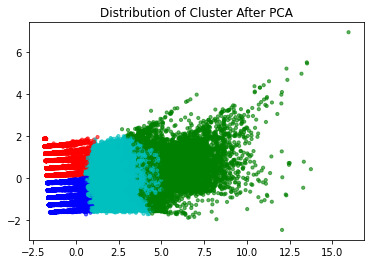

In [49]:

plt.title('Distribution of Cluster After PCA')
plt.scatter(x_pca_df[0], x_pca_df[1], c=xc.c, alpha = 0.6, s=10)
plt.show()

In [50]:
xtrain_pca

,0,1
0,-1.068524,-0.199950
1,-1.094959,0.158988
2,0.335118,-0.818493
3,2.017304,-0.421058
4,-1.363931,-1.266559
...,...,...
81006,-1.594191,0.823318
81007,-1.747377,1.518925
81008,-0.901077,-1.243830
81009,-1.629843,1.525343


In [51]:
xc_train

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,c
0,-0.564791,-0.350992,-0.253921,-0.527413,-0.489681,-0.408899,-0.109519,0,"(0, 0, 1)"
1,-0.472057,-0.469078,-0.253921,-0.472275,-0.512483,-0.422790,0.244975,3,"(0, 0.75, 0.75)"
2,0.501652,-0.219786,-0.253921,0.299647,0.650436,-0.520025,-0.818507,0,"(0, 0, 1)"
3,1.243525,1.013555,-0.253921,0.685609,1.391512,0.466215,-0.464013,2,"(1, 0, 0)"
4,-0.657525,-0.495319,-0.253921,-0.692825,-0.683501,-0.714495,-1.173001,0,"(0, 0, 1)"
...,...,...,...,...,...,...,...,...,...
81006,-0.750260,-0.495319,-0.253921,-0.692825,-0.717705,-0.686713,0.953962,3,"(0, 0.75, 0.75)"
81007,-0.796627,-0.534681,-0.253921,-0.692825,-0.843117,-0.686713,1.662950,3,"(0, 0.75, 0.75)"
81008,-0.286589,-0.311630,-0.253921,-0.527413,-0.432675,-0.603369,-1.173001,0,"(0, 0, 1)"
81009,-0.750260,-0.508440,-0.253921,-0.692825,-0.729106,-0.603369,1.662950,3,"(0, 0.75, 0.75)"


In [52]:
xtrain_pca

,0,1
0,-1.068524,-0.199950
1,-1.094959,0.158988
2,0.335118,-0.818493
3,2.017304,-0.421058
4,-1.363931,-1.266559
...,...,...
81006,-1.594191,0.823318
81007,-1.747377,1.518925
81008,-0.901077,-1.243830
81009,-1.629843,1.525343


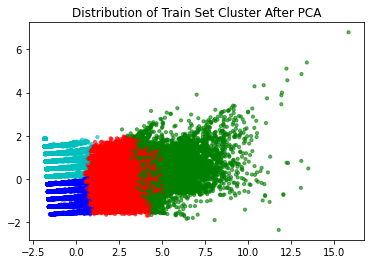

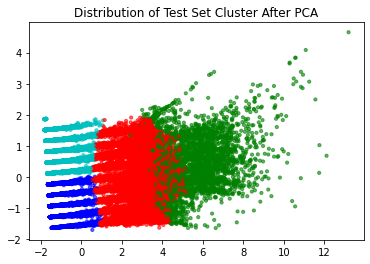

In [53]:

plt.title('Distribution of Train Set Cluster After PCA')
plt.scatter(xtrain_pca[0], xtrain_pca[1], c=xc_train.c, alpha = 0.6, s=10)
plt.show()


plt.title('Distribution of Test Set Cluster After PCA')
plt.scatter(xt_pca[0], xt_pca[1], c=xct.c, alpha = 0.6, s=10)
plt.show()

In [54]:
xc

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,cen_x,cen_y,c
0,-0.703572,-0.501203,-0.252438,-0.638028,-0.661014,-0.631799,1.663801,2,-0.530646,-0.394363,"(1, 0, 0)"
1,-0.703572,-0.487787,-0.252438,-0.638028,-0.729711,-0.533970,-1.174549,0,-0.511047,-0.367967,"(0, 0, 1)"
2,-0.192755,-0.367042,-0.252438,-0.638028,-0.145786,-0.603848,-1.174549,0,-0.511047,-0.367967,"(0, 0, 1)"
3,0.875317,0.062273,-0.252438,-0.250006,0.964817,-0.519994,-1.529343,0,-0.511047,-0.367967,"(0, 0, 1)"
4,-0.796448,-0.541451,-0.252438,-0.693459,-0.844206,-0.687702,1.309007,2,-0.530646,-0.394363,"(1, 0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...
135014,-0.239193,-0.353626,-0.252438,-0.693459,-0.569418,-0.561921,1.663801,2,-0.530646,-0.394363,"(1, 0, 0)"
135015,-0.424945,-0.393874,-0.252438,-0.305438,-0.351877,-0.408189,0.599420,2,-0.530646,-0.394363,"(1, 0, 0)"
135016,-0.657134,-0.487787,-0.252438,-0.638028,-0.638115,-0.687702,-0.110168,0,-0.511047,-0.367967,"(0, 0, 1)"
135017,2.639957,2.732077,9.340319,3.075895,2.808189,3.840400,0.244626,1,2.067711,2.258060,"(0, 0.5, 0)"


In [55]:
xc=xc.drop('c',axis=1)
xc=xc.drop('cen_x',axis=1)
xc=xc.drop('cen_y',axis=1)
xc

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster
0,-0.703572,-0.501203,-0.252438,-0.638028,-0.661014,-0.631799,1.663801,2
1,-0.703572,-0.487787,-0.252438,-0.638028,-0.729711,-0.533970,-1.174549,0
2,-0.192755,-0.367042,-0.252438,-0.638028,-0.145786,-0.603848,-1.174549,0
3,0.875317,0.062273,-0.252438,-0.250006,0.964817,-0.519994,-1.529343,0
4,-0.796448,-0.541451,-0.252438,-0.693459,-0.844206,-0.687702,1.309007,2
...,...,...,...,...,...,...,...,...
135014,-0.239193,-0.353626,-0.252438,-0.693459,-0.569418,-0.561921,1.663801,2
135015,-0.424945,-0.393874,-0.252438,-0.305438,-0.351877,-0.408189,0.599420,2
135016,-0.657134,-0.487787,-0.252438,-0.638028,-0.638115,-0.687702,-0.110168,0
135017,2.639957,2.732077,9.340319,3.075895,2.808189,3.840400,0.244626,1


In [56]:
x['cluster']=xc['cluster']
x

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster
0,4,4.0,0.0,1.0,23.0,6.0,9,2
1,4,5.0,0.0,1.0,17.0,13.0,1,0
2,15,14.0,0.0,1.0,68.0,8.0,1,0
3,38,46.0,0.0,8.0,165.0,14.0,0,0
4,2,1.0,0.0,0.0,7.0,2.0,8,2
...,...,...,...,...,...,...,...,...
135014,14,15.0,0.0,0.0,31.0,11.0,9,2
135015,10,12.0,0.0,7.0,50.0,22.0,6,2
135016,5,5.0,0.0,1.0,25.0,2.0,4,0
135017,76,245.0,40.0,68.0,326.0,326.0,5,1


In [57]:
x['apps/day']=x['sum apps']/x['total open']
x

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,apps/day
0,4,4.0,0.0,1.0,23.0,6.0,9,2,1.000000
1,4,5.0,0.0,1.0,17.0,13.0,1,0,1.250000
2,15,14.0,0.0,1.0,68.0,8.0,1,0,0.933333
3,38,46.0,0.0,8.0,165.0,14.0,0,0,1.210526
4,2,1.0,0.0,0.0,7.0,2.0,8,2,0.500000
...,...,...,...,...,...,...,...,...,...
135014,14,15.0,0.0,0.0,31.0,11.0,9,2,1.071429
135015,10,12.0,0.0,7.0,50.0,22.0,6,2,1.200000
135016,5,5.0,0.0,1.0,25.0,2.0,4,0,1.000000
135017,76,245.0,40.0,68.0,326.0,326.0,5,1,3.223684


In [58]:
x

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,apps/day
0,4,4.0,0.0,1.0,23.0,6.0,9,2,1.000000
1,4,5.0,0.0,1.0,17.0,13.0,1,0,1.250000
2,15,14.0,0.0,1.0,68.0,8.0,1,0,0.933333
3,38,46.0,0.0,8.0,165.0,14.0,0,0,1.210526
4,2,1.0,0.0,0.0,7.0,2.0,8,2,0.500000
...,...,...,...,...,...,...,...,...,...
135014,14,15.0,0.0,0.0,31.0,11.0,9,2,1.071429
135015,10,12.0,0.0,7.0,50.0,22.0,6,2,1.200000
135016,5,5.0,0.0,1.0,25.0,2.0,4,0,1.000000
135017,76,245.0,40.0,68.0,326.0,326.0,5,1,3.223684


In [59]:
c1=x.loc[x['cluster']==0]

c2=x.loc[x['cluster']==1]
c3=x.loc[x['cluster']==2]
c4=x.loc[x['cluster']==3]
c3

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,apps/day
0,4,4.0,0.0,1.0,23.0,6.0,9,2,1.000000
4,2,1.0,0.0,0.0,7.0,2.0,8,2,0.500000
6,10,NaN,NaN,NaN,NaN,NaN,6,2,NaN
8,12,8.0,0.0,4.0,42.0,32.0,9,2,0.666667
13,3,6.0,0.0,1.0,18.0,12.0,6,2,2.000000
...,...,...,...,...,...,...,...,...,...
135005,5,24.0,0.0,3.0,39.0,23.0,5,2,4.800000
135009,13,10.0,0.0,13.0,61.0,58.0,9,2,0.769231
135012,4,4.0,0.0,0.0,12.0,2.0,9,2,1.000000
135014,14,15.0,0.0,0.0,31.0,11.0,9,2,1.071429


In [60]:
c1

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,apps/day
1,4,5.0,0.0,1.0,17.0,13.0,1,0,1.250000
2,15,14.0,0.0,1.0,68.0,8.0,1,0,0.933333
3,38,46.0,0.0,8.0,165.0,14.0,0,0,1.210526
7,8,9.0,0.0,0.0,34.0,6.0,3,0,1.125000
9,4,4.0,0.0,3.0,21.0,11.0,2,0,1.000000
...,...,...,...,...,...,...,...,...,...
134998,4,3.0,0.0,0.0,8.0,0.0,0,0,0.750000
135001,2,3.0,0.0,0.0,11.0,2.0,0,0,1.500000
135008,6,4.0,0.0,0.0,33.0,2.0,1,0,0.666667
135011,12,12.0,0.0,8.0,62.0,54.0,2,0,1.000000


In [61]:
c1.columns

Index(['total open', 'sum apps', 'num_videos_rated', 'num_series_started',
       'num_videos_more_than_30_seconds', 'num_videos_completed', 'recency',
       'cluster', 'apps/day'],
      dtype='object')

In [62]:
dic={'col':list(c1.columns),'c1':list(np.mean(c1)),'c2':list(np.mean(c2)),'c3':list(np.mean(c3)),
     'c4':list(np.mean(c4))}
output=pd.DataFrame(dic)
output=output.T
output.columns=c1.columns
output


,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,apps/day
col,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,apps/day
c1,8.14844,13.935773,0.016905,3.557451,36.632786,17.362193,2.18508,0.0,1.635895
c2,63.696273,209.63501,11.203838,57.510026,279.923238,237.248616,3.886456,1.0,3.439176
c3,7.725454,11.820246,0.017457,3.282574,33.454271,16.691499,7.150173,2.0,1.477298
c4,47.699771,99.737367,1.883511,33.967853,197.147371,126.503124,3.371039,3.0,2.24047


In [63]:
output.drop('col',inplace=True,axis=0)
output

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,apps/day
c1,8.14844,13.935773,0.016905,3.557451,36.632786,17.362193,2.18508,0.0,1.635895
c2,63.696273,209.63501,11.203838,57.510026,279.923238,237.248616,3.886456,1.0,3.439176
c3,7.725454,11.820246,0.017457,3.282574,33.454271,16.691499,7.150173,2.0,1.477298
c4,47.699771,99.737367,1.883511,33.967853,197.147371,126.503124,3.371039,3.0,2.24047


In [64]:
output.drop('cluster',axis=1,inplace=True)
output

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,apps/day
c1,8.14844,13.935773,0.016905,3.557451,36.632786,17.362193,2.18508,1.635895
c2,63.696273,209.63501,11.203838,57.510026,279.923238,237.248616,3.886456,3.439176
c3,7.725454,11.820246,0.017457,3.282574,33.454271,16.691499,7.150173,1.477298
c4,47.699771,99.737367,1.883511,33.967853,197.147371,126.503124,3.371039,2.24047


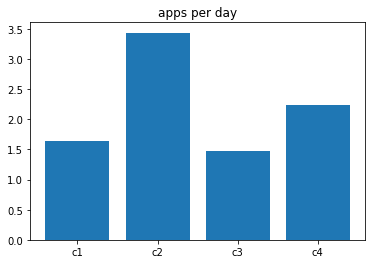

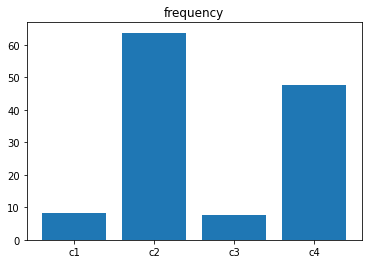

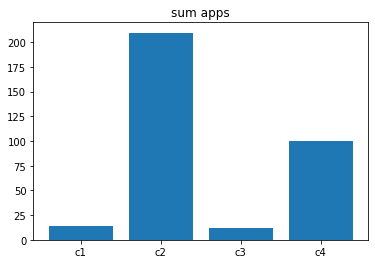

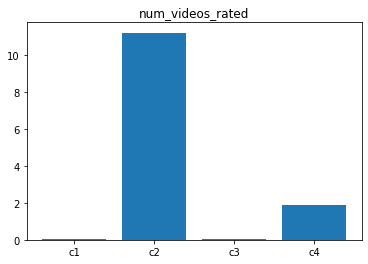

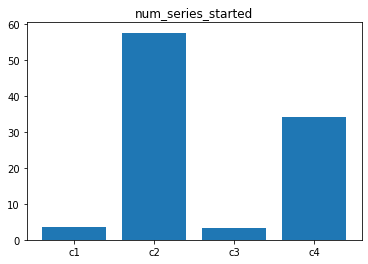

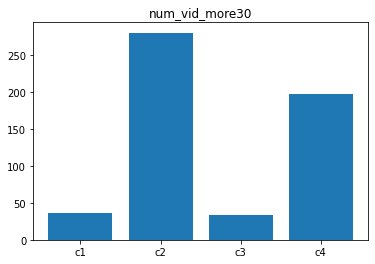

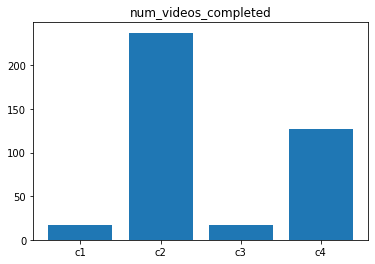

In [65]:
plt.title('apps per day')
plt.bar(output['apps/day'].keys(),output['apps/day'])
plt.show()

plt.title('frequency')
plt.bar(output['total open'].keys(),output['total open'])
plt.show()


plt.title('sum apps')
plt.bar(output['sum apps'].keys(),output['sum apps'])
plt.show()

plt.title('num_videos_rated')
plt.bar(output['num_videos_rated'].keys(),output['num_videos_rated'])
plt.show()

plt.title('num_series_started')

plt.bar(output['num_series_started'].keys(),output['num_series_started'])
plt.show()


plt.title('num_vid_more30')
plt.bar(output['num_videos_more_than_30_seconds'].keys(),output['num_videos_more_than_30_seconds'])
plt.show()


plt.title('num_videos_completed')
plt.bar(output['num_videos_completed'].keys(),output['num_videos_completed'])
plt.show()

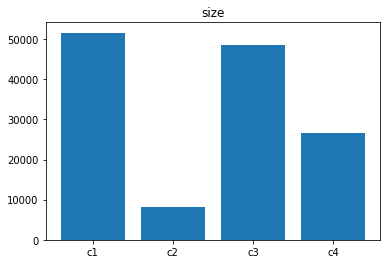

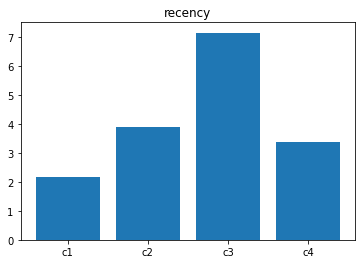

In [66]:
len(c4)

l=[len(c1),len(c2),len(c3),len(c4)]
output['size']=l
output
plt.title('size')
plt.bar(output['size'].keys(),output['size'])
plt.show()

plt.title('recency')
plt.bar(output['recency'].keys(),output['recency'])
plt.show()

In [67]:
des={'description':['new users','die hard fans','inactive users','regular users']}
des=pd.DataFrame(des)
des

,description
0,new users
1,die hard fans
2,inactive users
3,regular users


In [68]:
des.index=['c1','c2','c3','c4']
des

,description
c1,new users
c2,die hard fans
c3,inactive users
c4,regular users


In [69]:
output['description']=des['description']
output=output.T
output

,c1,c2,c3,c4
total open,8.14844,63.696273,7.725454,47.699771
sum apps,13.935773,209.63501,11.820246,99.737367
num_videos_rated,0.016905,11.203838,0.017457,1.883511
num_series_started,3.557451,57.510026,3.282574,33.967853
num_videos_more_than_30_seconds,36.632786,279.923238,33.454271,197.147371
num_videos_completed,17.362193,237.248616,16.691499,126.503124
recency,2.18508,3.886456,7.150173,3.371039
apps/day,1.635895,3.439176,1.477298,2.24047
size,51583,8129,48644,26663
description,new users,die hard fans,inactive users,regular users


In [70]:
output.columns=['segment 1','segment 2','segment 3','segment 4']
output

,segment 1,segment 2,segment 3,segment 4
total open,8.14844,63.696273,7.725454,47.699771
sum apps,13.935773,209.63501,11.820246,99.737367
num_videos_rated,0.016905,11.203838,0.017457,1.883511
num_series_started,3.557451,57.510026,3.282574,33.967853
num_videos_more_than_30_seconds,36.632786,279.923238,33.454271,197.147371
num_videos_completed,17.362193,237.248616,16.691499,126.503124
recency,2.18508,3.886456,7.150173,3.371039
apps/day,1.635895,3.439176,1.477298,2.24047
size,51583,8129,48644,26663
description,new users,die hard fans,inactive users,regular users


In [71]:
output

,segment 1,segment 2,segment 3,segment 4
total open,8.14844,63.696273,7.725454,47.699771
sum apps,13.935773,209.63501,11.820246,99.737367
num_videos_rated,0.016905,11.203838,0.017457,1.883511
num_series_started,3.557451,57.510026,3.282574,33.967853
num_videos_more_than_30_seconds,36.632786,279.923238,33.454271,197.147371
num_videos_completed,17.362193,237.248616,16.691499,126.503124
recency,2.18508,3.886456,7.150173,3.371039
apps/day,1.635895,3.439176,1.477298,2.24047
size,51583,8129,48644,26663
description,new users,die hard fans,inactive users,regular users


In [ ]:
#churn

In [186]:
xc

,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,clust
21433,21574909,7,15.0,0.0,3.0,38.0,22.0,4,0,2
18995,21397313,9,6.0,0.0,4.0,36.0,21.0,5,2,2
11566,20850757,30,25.0,0.0,18.0,138.0,14.0,2,0,2
83207,26150555,46,119.0,0.0,25.0,203.0,85.0,3,3,3
85256,26302455,5,4.0,0.0,0.0,21.0,0.0,1,0,3
...,...,...,...,...,...,...,...,...,...,...
90474,26690430,3,4.0,0.0,0.0,18.0,2.0,7,2,3
133553,29891468,2,1.0,0.0,0.0,7.0,2.0,9,2,1
36815,22708336,13,18.0,0.0,3.0,43.0,8.0,1,0,0
104736,27759092,3,3.0,0.0,0.0,17.0,8.0,9,2,1


In [187]:
subs['retarget_TF'].value_counts()

False    219825
True       7803
Name: retarget_TF, dtype: int64

In [188]:
subs['paid_TF'].value_counts()


False    135578
True      92050
Name: paid_TF, dtype: int64

In [244]:
churn=subs.loc[(subs['retarget_TF']==True)|( subs['paid_TF']==False)]
nochurn=subs.loc[~ (subs['retarget_TF']==True) & ~ ( subs['paid_TF']==False)]
nochurn

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
284782,24810928,base,NaN,comedy,access to exclusive content,20.051667,NaN,False,70.0,False,...,71.0,True,2020-03-18,False,0.0000,0.3303,ar,True,True,RAKBANK
192823,29726122,base,2.049135,comedy,access to exclusive content,20.051667,1.860289,False,61.0,False,...,NaN,True,2020-03-05,False,4.5875,0.3303,ar,True,False,Standard Charter
315863,20299962,base,3.002048,drama,access to exclusive content,34.551230,1.870503,False,23.0,False,...,NaN,True,2020-03-20,False,3.4498,0.0000,ar,True,False,RAKBANK
99989,21191741,NaN,NaN,NaN,expand regional access,34.551230,NaN,False,53.0,True,...,158.0,True,2019-07-26,False,9.2117,0.0367,ar,True,False,Standard Charter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254294,22117405,base,NaN,comedy,access to exclusive content,24.401536,NaN,False,30.0,False,...,33.0,True,2020-02-18,False,0.0000,0.0367,ar,True,True,Paypal
243775,26828621,base,3.672180,drama,access to exclusive content,27.301448,2.317104,False,44.0,False,...,NaN,True,2020-03-12,False,-0.6973,0.0000,ar,True,False,Standard Charter
136817,28920930,enhanced,NaN,regional,replace OTT,NaN,NaN,False,NaN,False,...,NaN,True,2019-09-29,False,NaN,NaN,ar,True,False,Standard Charter
230734,21928274,base,NaN,drama,replace OTT,NaN,NaN,False,NaN,False,...,NaN,True,2020-01-29,False,NaN,NaN,ar,True,False,RAKBANK


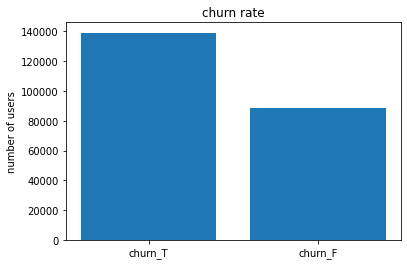

In [190]:
inp=['churn_T','churn_F']
plt.title('churn rate')
plt.bar(inp,[len(churn),len(nochurn)])
plt.ylabel('number of users')
plt.show()

In [191]:
len(churn)+len(nochurn)==len(subs)

True

In [245]:
churn['churn_TF']=1
nochurn['churn_TF']=0
churn

<ipython-input-245-e1d8d116b563>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['churn_TF']=1
<ipython-input-245-e1d8d116b563>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nochurn['churn_TF']=0


,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type,churn_TF
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN,1
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN,1
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN,1
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN,1
254782,24930568,base,NaN,comedy,access to exclusive content,25.851492,NaN,False,73.0,False,...,False,2020-03-09,False,0.0000,0.6606,ar,False,False,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603751,25835684,base,2.169904,drama,access to exclusive content,24.401536,1.881068,False,43.0,False,...,False,2020-01-16,False,0.0000,0.0000,ar,False,False,NaN,1
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,...,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN,1
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,...,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal,1
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,...,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN,1


In [246]:
bigdata = pd.concat([churn, nochurn])
bigdata

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type,churn_TF
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN,1
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN,1
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN,1
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN,1
254782,24930568,base,NaN,comedy,access to exclusive content,25.851492,NaN,False,73.0,False,...,False,2020-03-09,False,0.0000,0.6606,ar,False,False,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254294,22117405,base,NaN,comedy,access to exclusive content,24.401536,NaN,False,30.0,False,...,True,2020-02-18,False,0.0000,0.0367,ar,True,True,Paypal,0
243775,26828621,base,3.672180,drama,access to exclusive content,27.301448,2.317104,False,44.0,False,...,True,2020-03-12,False,-0.6973,0.0000,ar,True,False,Standard Charter,0
136817,28920930,enhanced,NaN,regional,replace OTT,NaN,NaN,False,NaN,False,...,True,2019-09-29,False,NaN,NaN,ar,True,False,Standard Charter,0
230734,21928274,base,NaN,drama,replace OTT,NaN,NaN,False,NaN,False,...,True,2020-01-29,False,NaN,NaN,ar,True,False,RAKBANK,0


In [247]:
subs['retarget_TF']

162502    False
380374    False
496617    False
356799    False
681701    False
          ...  
509326    False
229587     True
281340    False
87198     False
598241    False
Name: retarget_TF, Length: 227628, dtype: bool

In [195]:
churn

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type,churn_TF
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN,1
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN,1
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN,1
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN,1
254782,24930568,base,NaN,comedy,access to exclusive content,25.851492,NaN,False,73.0,False,...,False,2020-03-09,False,0.0000,0.6606,ar,False,False,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603751,25835684,base,2.169904,drama,access to exclusive content,24.401536,1.881068,False,43.0,False,...,False,2020-01-16,False,0.0000,0.0000,ar,False,False,NaN,1
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,...,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN,1
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,...,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal,1
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,...,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN,1


In [248]:
colskeep=['subid','package_type','preferred_genre','intended_use','weekly_consumption_hour',
         'age','num_ideal_streaming_services','revenue_net','join_fee','churn_TF']

#subs2=subs[colskeep]
subs2=bigdata[colskeep]
subs2

,subid,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,num_ideal_streaming_services,revenue_net,join_fee,churn_TF
380374,23383224,base,comedy,access to exclusive content,22.951579,70.0,NaN,0.0000,0.3303,1
496617,26844789,enhanced,regional,replace OTT,36.001186,25.0,1.951776,0.0000,0.1101,1
356799,29417030,base,drama,replace OTT,20.051667,30.0,NaN,0.0000,0.0367,1
681701,26723159,base,comedy,replace OTT,22.951579,28.0,2.506384,0.0000,0.0367,1
254782,24930568,base,comedy,access to exclusive content,25.851492,73.0,NaN,0.0000,0.6606,1
...,...,...,...,...,...,...,...,...,...,...
254294,22117405,base,comedy,access to exclusive content,24.401536,30.0,NaN,0.0000,0.0367,0
243775,26828621,base,drama,access to exclusive content,27.301448,44.0,2.317104,-0.6973,0.0000,0
136817,28920930,enhanced,regional,replace OTT,NaN,NaN,NaN,NaN,NaN,0
230734,21928274,base,drama,replace OTT,NaN,NaN,NaN,NaN,NaN,0


In [249]:
colskeep=['subid','package_type','preferred_genre','intended_use','weekly_consumption_hour',
         'age','num_ideal_streaming_services','revenue_net','join_fee']
subs[colskeep].T

,162502,380374,496617,356799,681701,284782,192823,315863,254782,681969,...,303902,378377,230734,577745,603751,509326,229587,281340,87198,598241
subid,21724479,23383224,26844789,29417030,26723159,24810928,29726122,20299962,24930568,23452753,...,22218943,25492551,21928274,25549852,25835684,21434712,25843074,24799085,21308040,20166335
package_type,economy,base,enhanced,base,base,base,base,base,base,economy,...,economy,base,base,enhanced,base,enhanced,enhanced,base,base,base
preferred_genre,comedy,comedy,regional,drama,comedy,comedy,comedy,drama,comedy,drama,...,comedy,comedy,drama,comedy,drama,comedy,comedy,comedy,comedy,comedy
intended_use,access to exclusive content,access to exclusive content,replace OTT,replace OTT,replace OTT,access to exclusive content,access to exclusive content,access to exclusive content,access to exclusive content,replace OTT,...,replace OTT,access to exclusive content,replace OTT,access to exclusive content,access to exclusive content,supplement OTT,replace OTT,access to exclusive content,access to exclusive content,replace OTT
weekly_consumption_hour,NaN,22.951579,36.001186,20.051667,22.951579,20.051667,20.051667,34.55123,25.851492,28.751405,...,37.451142,30.201361,NaN,28.751405,24.401536,28.751405,27.301448,31.651317,NaN,25.851492
age,NaN,70.0,25.0,30.0,28.0,70.0,61.0,23.0,73.0,71.0,...,67.0,32.0,NaN,61.0,43.0,38.0,49.0,45.0,NaN,55.0
num_ideal_streaming_services,NaN,NaN,1.951776,NaN,2.506384,NaN,1.860289,1.870503,NaN,1.888272,...,NaN,1.968236,NaN,NaN,1.881068,1.905485,1.835189,NaN,NaN,NaN
revenue_net,NaN,0.0,0.0,0.0,0.0,0.0,4.5875,3.4498,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,4.5875,0.0,NaN,0.0
join_fee,NaN,0.3303,0.1101,0.0367,0.0367,0.3303,0.3303,0.0,0.6606,0.3303,...,0.0367,0.0,NaN,0.3303,0.0,0.3303,0.3303,0.0367,NaN,0.0367


In [198]:
df_final2

,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster
0,20000062,4,4.0,0.0,1.0,23.0,6.0,9,2
1,20000405,4,5.0,0.0,1.0,17.0,13.0,1,0
2,20000604,15,14.0,0.0,1.0,68.0,8.0,1,0
3,20000685,38,46.0,0.0,8.0,165.0,14.0,0,0
4,20000741,2,1.0,0.0,0.0,7.0,2.0,8,2
...,...,...,...,...,...,...,...,...,...
135014,29999740,14,15.0,0.0,0.0,31.0,11.0,9,2
135015,29999820,10,12.0,0.0,7.0,50.0,22.0,6,2
135016,29999822,5,5.0,0.0,1.0,25.0,2.0,4,0
135017,29999889,76,245.0,40.0,68.0,326.0,326.0,5,1


In [250]:
#df_final2['cluster']=x['cluster']
#df_final2.drop('cluster',axis=1,inplace=True)
df_final2.drop('last open',axis=1,inplace=True)
df_final2

KeyError: "['last open'] not found in axis"

In [254]:
cluster_keep=df_final2.columns
cluster_keep

Index(['subid', 'total open', 'sum apps', 'num_videos_rated',
       'num_series_started', 'num_videos_more_than_30_seconds',
       'num_videos_completed', 'recency', 'cluster'],
      dtype='object')

In [255]:
subs2

,subid,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,num_ideal_streaming_services,revenue_net,join_fee,churn_TF
380374,23383224,base,comedy,access to exclusive content,22.951579,70.0,NaN,0.0000,0.3303,1
496617,26844789,enhanced,regional,replace OTT,36.001186,25.0,1.951776,0.0000,0.1101,1
356799,29417030,base,drama,replace OTT,20.051667,30.0,NaN,0.0000,0.0367,1
681701,26723159,base,comedy,replace OTT,22.951579,28.0,2.506384,0.0000,0.0367,1
254782,24930568,base,comedy,access to exclusive content,25.851492,73.0,NaN,0.0000,0.6606,1
...,...,...,...,...,...,...,...,...,...,...
254294,22117405,base,comedy,access to exclusive content,24.401536,30.0,NaN,0.0000,0.0367,0
243775,26828621,base,drama,access to exclusive content,27.301448,44.0,2.317104,-0.6973,0.0000,0
136817,28920930,enhanced,regional,replace OTT,NaN,NaN,NaN,NaN,NaN,0
230734,21928274,base,drama,replace OTT,NaN,NaN,NaN,NaN,NaN,0


In [256]:
x=df_final2.merge(subs2,left_on='subid',right_on='subid',how='inner')
x

,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,num_ideal_streaming_services,revenue_net,join_fee,churn_TF
0,20000062,4,4.0,0.0,1.0,23.0,6.0,9,2,NaN,NaN,expand regional access,27.301448,59.0,2.342891,0.0000,0.0367,1
1,20000405,4,5.0,0.0,1.0,17.0,13.0,1,0,enhanced,comedy,access to exclusive content,33.101274,48.0,2.375602,0.0000,0.6606,1
2,20000604,15,14.0,0.0,1.0,68.0,8.0,1,0,economy,comedy,replace OTT,NaN,NaN,NaN,NaN,NaN,0
3,20000685,38,46.0,0.0,8.0,165.0,14.0,0,0,base,comedy,other,25.851492,67.0,1.873939,3.6700,0.3303,1
4,20000741,2,1.0,0.0,0.0,7.0,2.0,8,2,base,comedy,access to exclusive content,25.851492,75.0,NaN,0.0000,0.0367,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135014,29999740,14,15.0,0.0,0.0,31.0,11.0,9,2,NaN,NaN,expand regional access,21.501623,37.0,NaN,0.0000,0.0367,1
135015,29999820,10,12.0,0.0,7.0,50.0,22.0,6,2,base,comedy,replace OTT,21.501623,66.0,1.885493,0.0000,0.0367,1
135016,29999822,5,5.0,0.0,1.0,25.0,2.0,4,0,base,drama,access to exclusive content,30.201361,40.0,2.603838,0.0000,0.1101,1
135017,29999889,76,245.0,40.0,68.0,326.0,326.0,5,1,economy,comedy,access to exclusive content,NaN,NaN,NaN,NaN,NaN,0


In [89]:
subs

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,0.0,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,1.0,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,0.0,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,9.0,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,...,8.0,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,...,NaN,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,...,31.0,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN
87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-01,False,NaN,NaN,ar,True,False,Paypal


In [253]:
x

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,preferred_genre_international,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT
21433,7,15.0,0.0,3.0,38.0,22.0,4,0,30.201361,33.000000,...,0,0,0,1,0,0,0,0,0,0
18995,9,6.0,0.0,4.0,36.0,21.0,5,2,24.401536,29.000000,...,0,0,0,1,0,0,0,0,0,0
11566,30,25.0,0.0,18.0,138.0,14.0,2,0,31.651317,39.000000,...,0,0,0,0,0,0,0,0,1,0
83207,46,119.0,0.0,25.0,203.0,85.0,3,3,27.953194,199.938679,...,0,0,0,1,0,0,0,0,0,0
85256,5,4.0,0.0,0.0,21.0,0.0,1,0,41.801011,48.000000,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90474,3,4.0,0.0,0.0,18.0,2.0,7,2,28.751405,60.000000,...,0,0,0,0,0,0,0,0,1,0
133553,2,1.0,0.0,0.0,7.0,2.0,9,2,33.101274,79.000000,...,0,0,0,0,0,1,0,0,0,0
36815,13,18.0,0.0,3.0,43.0,8.0,1,0,24.401536,57.000000,...,0,0,0,0,0,0,0,0,0,1
104736,3,3.0,0.0,0.0,17.0,8.0,9,2,27.301448,30.000000,...,0,0,0,0,0,0,0,1,0,0


In [257]:

from sklearn.model_selection import train_test_split as tts


train_set,test_set=tts(x,test_size=0.4,random_state=88, shuffle=True)
train_set
#model=xgb()

,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,num_ideal_streaming_services,revenue_net,join_fee,churn_TF
21433,21574909,7,15.0,0.0,3.0,38.0,22.0,4,0,enhanced,comedy,access to exclusive content,30.201361,33.0,1.906788,0.00,0.6606,1
18995,21397313,9,6.0,0.0,4.0,36.0,21.0,5,2,enhanced,drama,access to exclusive content,24.401536,29.0,1.870374,0.00,0.0367,1
11566,20850757,30,25.0,0.0,18.0,138.0,14.0,2,0,enhanced,comedy,replace OTT,31.651317,39.0,1.834984,3.67,0.0367,0
83207,26150555,46,119.0,0.0,25.0,203.0,85.0,3,3,base,comedy,access to exclusive content,NaN,NaN,NaN,NaN,NaN,0
85256,26302455,5,4.0,0.0,0.0,21.0,0.0,1,0,enhanced,comedy,supplement OTT,41.801011,48.0,NaN,0.00,0.0367,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90474,26690430,3,4.0,0.0,0.0,18.0,2.0,7,2,economy,comedy,replace OTT,28.751405,60.0,NaN,0.00,0.0367,1
133553,29891468,2,1.0,0.0,0.0,7.0,2.0,9,2,NaN,NaN,expand international access,33.101274,79.0,NaN,0.00,0.0367,1
36815,22708336,13,18.0,0.0,3.0,43.0,8.0,1,0,enhanced,drama,supplement OTT,24.401536,57.0,1.926442,0.00,0.3303,0
104736,27759092,3,3.0,0.0,0.0,17.0,8.0,9,2,NaN,NaN,other,27.301448,30.0,NaN,0.00,0.0367,1


In [258]:
y=train_set['churn_TF']
x=train_set.drop('churn_TF',axis=1)
y_t=test_set['churn_TF']
x_t=test_set.drop('churn_TF',axis=1)

x

,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,num_ideal_streaming_services,revenue_net,join_fee
21433,21574909,7,15.0,0.0,3.0,38.0,22.0,4,0,enhanced,comedy,access to exclusive content,30.201361,33.0,1.906788,0.00,0.6606
18995,21397313,9,6.0,0.0,4.0,36.0,21.0,5,2,enhanced,drama,access to exclusive content,24.401536,29.0,1.870374,0.00,0.0367
11566,20850757,30,25.0,0.0,18.0,138.0,14.0,2,0,enhanced,comedy,replace OTT,31.651317,39.0,1.834984,3.67,0.0367
83207,26150555,46,119.0,0.0,25.0,203.0,85.0,3,3,base,comedy,access to exclusive content,NaN,NaN,NaN,NaN,NaN
85256,26302455,5,4.0,0.0,0.0,21.0,0.0,1,0,enhanced,comedy,supplement OTT,41.801011,48.0,NaN,0.00,0.0367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90474,26690430,3,4.0,0.0,0.0,18.0,2.0,7,2,economy,comedy,replace OTT,28.751405,60.0,NaN,0.00,0.0367
133553,29891468,2,1.0,0.0,0.0,7.0,2.0,9,2,NaN,NaN,expand international access,33.101274,79.0,NaN,0.00,0.0367
36815,22708336,13,18.0,0.0,3.0,43.0,8.0,1,0,enhanced,drama,supplement OTT,24.401536,57.0,1.926442,0.00,0.3303
104736,27759092,3,3.0,0.0,0.0,17.0,8.0,9,2,NaN,NaN,other,27.301448,30.0,NaN,0.00,0.0367


In [259]:
x_t

,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,num_ideal_streaming_services,revenue_net,join_fee
22897,21686118,1,0.0,0.0,1.0,0.0,0.0,8,2,enhanced,comedy,access to exclusive content,25.851492,25.0,1.919681,9.1750,0.0367
123440,29143861,10,14.0,0.0,7.0,47.0,35.0,9,2,NaN,NaN,education,21.501623,45.0,1.965643,0.0000,0.0000
84500,26244558,6,13.0,0.0,2.0,28.0,13.0,6,2,enhanced,comedy,replace OTT,27.301448,20.0,1.871880,0.0000,0.0367
33950,22499516,46,355.0,0.0,42.0,206.0,179.0,2,3,base,comedy,access to exclusive content,24.401536,46.0,1.922213,4.5875,0.0367
93386,26907868,6,4.0,0.0,0.0,26.0,2.0,1,0,enhanced,drama,replace OTT,28.751405,34.0,NaN,0.0000,0.3303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82986,26132770,44,118.0,10.0,41.0,194.0,118.0,2,3,enhanced,regional,access to exclusive content,25.851492,28.0,1.857409,3.9269,0.0367
113554,28402529,63,95.0,0.0,22.0,222.0,17.0,7,3,NaN,NaN,expand regional access,46.150880,58.0,3.029794,9.1750,0.0367
61118,24503371,1,0.0,0.0,0.0,0.0,0.0,5,2,enhanced,comedy,replace OTT,33.101274,32.0,NaN,0.0000,0.0367
46853,23449519,30,67.0,1.0,26.0,141.0,108.0,0,3,base,comedy,access to exclusive content,33.101274,60.0,1.942142,4.5875,0.6606


In [260]:
xc=x[cluster_keep]
xc

,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster
21433,21574909,7,15.0,0.0,3.0,38.0,22.0,4,0
18995,21397313,9,6.0,0.0,4.0,36.0,21.0,5,2
11566,20850757,30,25.0,0.0,18.0,138.0,14.0,2,0
83207,26150555,46,119.0,0.0,25.0,203.0,85.0,3,3
85256,26302455,5,4.0,0.0,0.0,21.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...
90474,26690430,3,4.0,0.0,0.0,18.0,2.0,7,2
133553,29891468,2,1.0,0.0,0.0,7.0,2.0,9,2
36815,22708336,13,18.0,0.0,3.0,43.0,8.0,1,0
104736,27759092,3,3.0,0.0,0.0,17.0,8.0,9,2


In [261]:
xct=x_t[cluster_keep]
xct.fillna(xc.mean(),inplace=True)
xct

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster
22897,21686118,1,0.0,0.0,1.0,0.0,0.0,8,2
123440,29143861,10,14.0,0.0,7.0,47.0,35.0,9,2
84500,26244558,6,13.0,0.0,2.0,28.0,13.0,6,2
33950,22499516,46,355.0,0.0,42.0,206.0,179.0,2,3
93386,26907868,6,4.0,0.0,0.0,26.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...
82986,26132770,44,118.0,10.0,41.0,194.0,118.0,2,3
113554,28402529,63,95.0,0.0,22.0,222.0,17.0,7,3
61118,24503371,1,0.0,0.0,0.0,0.0,0.0,5,2
46853,23449519,30,67.0,1.0,26.0,141.0,108.0,0,3


In [262]:
xc.fillna(xc.mean(),inplace=True)
xc.isnull().sum()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


subid                              0
total open                         0
sum apps                           0
num_videos_rated                   0
num_series_started                 0
num_videos_more_than_30_seconds    0
num_videos_completed               0
recency                            0
cluster                            0
dtype: int64

In [263]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0)
clust=kmeans.fit_predict(xc)
#silhouette_avg = silhouette_score(xc, clust)
#print('score for train_set:',silhouette_avg)
#xc['cluster']=clust

# get centroids
centroids = kmeans.cluster_centers_
#score for train: 0.4390529467222094
centroids

array([[2.37323935e+07, 1.91280705e+01, 4.13201519e+01, 1.09065184e+00,
        1.24806534e+01, 8.07167525e+01, 5.12649650e+01, 4.30665610e+00,
        1.36529319e+00],
       [2.87437671e+07, 1.93138625e+01, 4.28607520e+01, 1.08020354e+00,
        1.27399639e+01, 8.15525182e+01, 5.21630344e+01, 4.28375208e+00,
        1.36919542e+00],
       [2.12395725e+07, 1.92767531e+01, 4.15002857e+01, 1.07666867e+00,
        1.25997082e+01, 8.10602189e+01, 5.11280558e+01, 4.32409508e+00,
        1.38238485e+00],
       [2.62330370e+07, 1.90016432e+01, 4.13074116e+01, 1.04191555e+00,
        1.24382944e+01, 8.04597478e+01, 5.11818573e+01, 4.32161530e+00,
        1.37041279e+00]])

In [264]:
clust_t=kmeans.predict(xct)

In [265]:
xc['clust']=clust
xc

<ipython-input-265-803d5a036ec7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xc['clust']=clust


,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,clust
21433,21574909,7,15.0,0.0,3.0,38.0,22.0,4,0,2
18995,21397313,9,6.0,0.0,4.0,36.0,21.0,5,2,2
11566,20850757,30,25.0,0.0,18.0,138.0,14.0,2,0,2
83207,26150555,46,119.0,0.0,25.0,203.0,85.0,3,3,3
85256,26302455,5,4.0,0.0,0.0,21.0,0.0,1,0,3
...,...,...,...,...,...,...,...,...,...,...
90474,26690430,3,4.0,0.0,0.0,18.0,2.0,7,2,3
133553,29891468,2,1.0,0.0,0.0,7.0,2.0,9,2,1
36815,22708336,13,18.0,0.0,3.0,43.0,8.0,1,0,0
104736,27759092,3,3.0,0.0,0.0,17.0,8.0,9,2,1


In [266]:
x_t['clust']=clust_t
x_t

,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,num_ideal_streaming_services,revenue_net,join_fee,clust
22897,21686118,1,0.0,0.0,1.0,0.0,0.0,8,2,enhanced,comedy,access to exclusive content,25.851492,25.0,1.919681,9.1750,0.0367,2
123440,29143861,10,14.0,0.0,7.0,47.0,35.0,9,2,NaN,NaN,education,21.501623,45.0,1.965643,0.0000,0.0000,1
84500,26244558,6,13.0,0.0,2.0,28.0,13.0,6,2,enhanced,comedy,replace OTT,27.301448,20.0,1.871880,0.0000,0.0367,3
33950,22499516,46,355.0,0.0,42.0,206.0,179.0,2,3,base,comedy,access to exclusive content,24.401536,46.0,1.922213,4.5875,0.0367,0
93386,26907868,6,4.0,0.0,0.0,26.0,2.0,1,0,enhanced,drama,replace OTT,28.751405,34.0,NaN,0.0000,0.3303,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82986,26132770,44,118.0,10.0,41.0,194.0,118.0,2,3,enhanced,regional,access to exclusive content,25.851492,28.0,1.857409,3.9269,0.0367,3
113554,28402529,63,95.0,0.0,22.0,222.0,17.0,7,3,NaN,NaN,expand regional access,46.150880,58.0,3.029794,9.1750,0.0367,1
61118,24503371,1,0.0,0.0,0.0,0.0,0.0,5,2,enhanced,comedy,replace OTT,33.101274,32.0,NaN,0.0000,0.0367,0
46853,23449519,30,67.0,1.0,26.0,141.0,108.0,0,3,base,comedy,access to exclusive content,33.101274,60.0,1.942142,4.5875,0.6606,0


In [267]:
x['clust']=clust
x

,subid,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,num_ideal_streaming_services,revenue_net,join_fee,clust
21433,21574909,7,15.0,0.0,3.0,38.0,22.0,4,0,enhanced,comedy,access to exclusive content,30.201361,33.0,1.906788,0.00,0.6606,2
18995,21397313,9,6.0,0.0,4.0,36.0,21.0,5,2,enhanced,drama,access to exclusive content,24.401536,29.0,1.870374,0.00,0.0367,2
11566,20850757,30,25.0,0.0,18.0,138.0,14.0,2,0,enhanced,comedy,replace OTT,31.651317,39.0,1.834984,3.67,0.0367,2
83207,26150555,46,119.0,0.0,25.0,203.0,85.0,3,3,base,comedy,access to exclusive content,NaN,NaN,NaN,NaN,NaN,3
85256,26302455,5,4.0,0.0,0.0,21.0,0.0,1,0,enhanced,comedy,supplement OTT,41.801011,48.0,NaN,0.00,0.0367,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90474,26690430,3,4.0,0.0,0.0,18.0,2.0,7,2,economy,comedy,replace OTT,28.751405,60.0,NaN,0.00,0.0367,3
133553,29891468,2,1.0,0.0,0.0,7.0,2.0,9,2,NaN,NaN,expand international access,33.101274,79.0,NaN,0.00,0.0367,1
36815,22708336,13,18.0,0.0,3.0,43.0,8.0,1,0,enhanced,drama,supplement OTT,24.401536,57.0,1.926442,0.00,0.3303,0
104736,27759092,3,3.0,0.0,0.0,17.0,8.0,9,2,NaN,NaN,other,27.301448,30.0,NaN,0.00,0.0367,1


In [268]:
x=x.drop('subid',axis=1)
x

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,package_type,preferred_genre,intended_use,weekly_consumption_hour,age,num_ideal_streaming_services,revenue_net,join_fee,clust
21433,7,15.0,0.0,3.0,38.0,22.0,4,0,enhanced,comedy,access to exclusive content,30.201361,33.0,1.906788,0.00,0.6606,2
18995,9,6.0,0.0,4.0,36.0,21.0,5,2,enhanced,drama,access to exclusive content,24.401536,29.0,1.870374,0.00,0.0367,2
11566,30,25.0,0.0,18.0,138.0,14.0,2,0,enhanced,comedy,replace OTT,31.651317,39.0,1.834984,3.67,0.0367,2
83207,46,119.0,0.0,25.0,203.0,85.0,3,3,base,comedy,access to exclusive content,NaN,NaN,NaN,NaN,NaN,3
85256,5,4.0,0.0,0.0,21.0,0.0,1,0,enhanced,comedy,supplement OTT,41.801011,48.0,NaN,0.00,0.0367,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90474,3,4.0,0.0,0.0,18.0,2.0,7,2,economy,comedy,replace OTT,28.751405,60.0,NaN,0.00,0.0367,3
133553,2,1.0,0.0,0.0,7.0,2.0,9,2,NaN,NaN,expand international access,33.101274,79.0,NaN,0.00,0.0367,1
36815,13,18.0,0.0,3.0,43.0,8.0,1,0,enhanced,drama,supplement OTT,24.401536,57.0,1.926442,0.00,0.3303,0
104736,3,3.0,0.0,0.0,17.0,8.0,9,2,NaN,NaN,other,27.301448,30.0,NaN,0.00,0.0367,1


In [269]:
x_t=x_t.drop('subid',axis=1)

In [270]:
cluster_keep

Index(['subid', 'total open', 'sum apps', 'num_videos_rated',
       'num_series_started', 'num_videos_more_than_30_seconds',
       'num_videos_completed', 'recency', 'cluster'],
      dtype='object')

In [271]:
x=pd.get_dummies(x)

#x=x.drop('subid',axis=1)
x.fillna(x.mean(),inplace=True)

x_t=pd.get_dummies(x_t)

#x_t=x_t.drop('subid',axis=1)
x_t.fillna(x.mean(),inplace=True)
x_t

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,preferred_genre_international,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT
22897,1,0.0,0.0,1.0,0.0,0.0,8,2,25.851492,25.0,...,0,0,0,1,0,0,0,0,0,0
123440,10,14.0,0.0,7.0,47.0,35.0,9,2,21.501623,45.0,...,0,0,0,0,1,0,0,0,0,0
84500,6,13.0,0.0,2.0,28.0,13.0,6,2,27.301448,20.0,...,0,0,0,0,0,0,0,0,1,0
33950,46,355.0,0.0,42.0,206.0,179.0,2,3,24.401536,46.0,...,0,0,0,1,0,0,0,0,0,0
93386,6,4.0,0.0,0.0,26.0,2.0,1,0,28.751405,34.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82986,44,118.0,10.0,41.0,194.0,118.0,2,3,25.851492,28.0,...,0,0,1,1,0,0,0,0,0,0
113554,63,95.0,0.0,22.0,222.0,17.0,7,3,46.150880,58.0,...,0,0,0,0,0,0,1,0,0,0
61118,1,0.0,0.0,0.0,0.0,0.0,5,2,33.101274,32.0,...,0,0,0,0,0,0,0,0,1,0
46853,30,67.0,1.0,26.0,141.0,108.0,0,3,33.101274,60.0,...,0,0,0,1,0,0,0,0,0,0


In [272]:
x_t

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,preferred_genre_international,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT
22897,1,0.0,0.0,1.0,0.0,0.0,8,2,25.851492,25.0,...,0,0,0,1,0,0,0,0,0,0
123440,10,14.0,0.0,7.0,47.0,35.0,9,2,21.501623,45.0,...,0,0,0,0,1,0,0,0,0,0
84500,6,13.0,0.0,2.0,28.0,13.0,6,2,27.301448,20.0,...,0,0,0,0,0,0,0,0,1,0
33950,46,355.0,0.0,42.0,206.0,179.0,2,3,24.401536,46.0,...,0,0,0,1,0,0,0,0,0,0
93386,6,4.0,0.0,0.0,26.0,2.0,1,0,28.751405,34.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82986,44,118.0,10.0,41.0,194.0,118.0,2,3,25.851492,28.0,...,0,0,1,1,0,0,0,0,0,0
113554,63,95.0,0.0,22.0,222.0,17.0,7,3,46.150880,58.0,...,0,0,0,0,0,0,1,0,0,0
61118,1,0.0,0.0,0.0,0.0,0.0,5,2,33.101274,32.0,...,0,0,0,0,0,0,0,0,1,0
46853,30,67.0,1.0,26.0,141.0,108.0,0,3,33.101274,60.0,...,0,0,0,1,0,0,0,0,0,0


In [274]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, random_state = 42)
model.fit(x,y)
pred=model.predict(x_t)
accuracy_score(pred,y_t)
#0.9671715301436824

0.9671715301436824

In [275]:
from sklearn.metrics import precision_score
precision_score(pred,y_t)
#0.9734780556866447

0.9735095170677993

In [276]:
x_t

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,preferred_genre_international,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT
22897,1,0.0,0.0,1.0,0.0,0.0,8,2,25.851492,25.0,...,0,0,0,1,0,0,0,0,0,0
123440,10,14.0,0.0,7.0,47.0,35.0,9,2,21.501623,45.0,...,0,0,0,0,1,0,0,0,0,0
84500,6,13.0,0.0,2.0,28.0,13.0,6,2,27.301448,20.0,...,0,0,0,0,0,0,0,0,1,0
33950,46,355.0,0.0,42.0,206.0,179.0,2,3,24.401536,46.0,...,0,0,0,1,0,0,0,0,0,0
93386,6,4.0,0.0,0.0,26.0,2.0,1,0,28.751405,34.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82986,44,118.0,10.0,41.0,194.0,118.0,2,3,25.851492,28.0,...,0,0,1,1,0,0,0,0,0,0
113554,63,95.0,0.0,22.0,222.0,17.0,7,3,46.150880,58.0,...,0,0,0,0,0,0,1,0,0,0
61118,1,0.0,0.0,0.0,0.0,0.0,5,2,33.101274,32.0,...,0,0,0,0,0,0,0,0,1,0
46853,30,67.0,1.0,26.0,141.0,108.0,0,3,33.101274,60.0,...,0,0,0,1,0,0,0,0,0,0


In [277]:
roc_auc_score(pred,y_t)

0.9663751088243746

In [222]:
y.value_counts()

1    47879
0    33132
Name: churn_TF, dtype: int64

In [278]:
from sklearn.metrics import f1_score
f1_score(pred,y_t)

0.9721484786126078

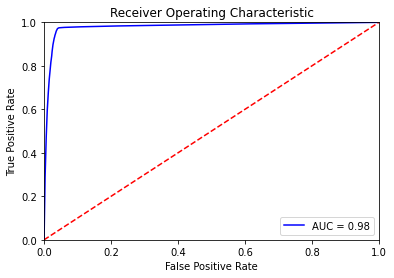

In [279]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(x_t)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_t, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [118]:
forest_importances['total open']

0.1683879743539807

In [280]:
imp=model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
#std=std[:5]

import pandas as pd
feature_names=x_t.columns
forest_importances = pd.Series(imp, index=feature_names)
forest_importances=forest_importances[:13]
feature_names=list(forest_importances.keys())[:13]

'''feature_names=x_t.columns
forest_importances = pd.Series(imp, index=feature_names)
forest_importances
fi=sorted(forest_importances,reverse=True)'''

'feature_names=x_t.columns\nforest_importances = pd.Series(imp, index=feature_names)\nforest_importances\nfi=sorted(forest_importances,reverse=True)'

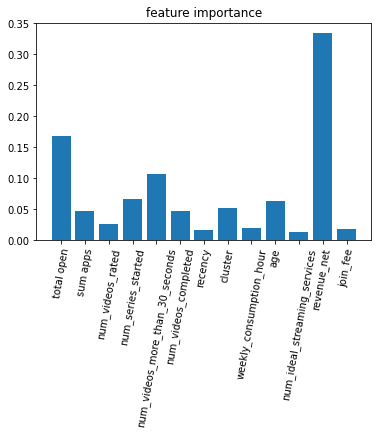

In [281]:
#figure(figsize=(15,8))
plt.title('feature importance')
plt.bar(feature_names,forest_importances)
plt.xticks(rotation=80)

plt.show()

In [282]:
pred = model.predict_proba(x_t)
pred=pd.DataFrame(pred)
pred[1]


0        0.03
1        0.99
2        0.97
3        0.04
4        0.89
         ... 
54003    0.17
54004    0.04
54005    0.98
54006    0.03
54007    0.95
Name: 1, Length: 54008, dtype: float64

In [283]:
#x_t['churn_TF']=y_t
#x_t

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,churn_TF
22897,1,0.0,0.0,1.0,0.0,0.0,8,2,25.851492,25.0,...,0,0,1,0,0,0,0,0,0,0
123440,10,14.0,0.0,7.0,47.0,35.0,9,2,21.501623,45.0,...,0,0,0,1,0,0,0,0,0,1
84500,6,13.0,0.0,2.0,28.0,13.0,6,2,27.301448,20.0,...,0,0,0,0,0,0,0,1,0,1
33950,46,355.0,0.0,42.0,206.0,179.0,2,3,24.401536,46.0,...,0,0,1,0,0,0,0,0,0,0
93386,6,4.0,0.0,0.0,26.0,2.0,1,0,28.751405,34.0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82986,44,118.0,10.0,41.0,194.0,118.0,2,3,25.851492,28.0,...,0,1,1,0,0,0,0,0,0,0
113554,63,95.0,0.0,22.0,222.0,17.0,7,3,46.150880,58.0,...,0,0,0,0,0,1,0,0,0,0
61118,1,0.0,0.0,0.0,0.0,0.0,5,2,33.101274,32.0,...,0,0,0,0,0,0,0,1,0,1
46853,30,67.0,1.0,26.0,141.0,108.0,0,3,33.101274,60.0,...,0,0,1,0,0,0,0,0,0,0


In [285]:
colsdrop=['intended_use_replace OTT','intended_use_other','preferred_genre_drama','package_type_base','preferred_genre_other']
xd=x.drop(colsdrop,axis=1)
xd

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,package_type_economy,package_type_enhanced,preferred_genre_comedy,preferred_genre_international,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_supplement OTT
21433,7,15.0,0.0,3.0,38.0,22.0,4,0,30.201361,33.000000,...,0,1,1,0,0,1,0,0,0,0
18995,9,6.0,0.0,4.0,36.0,21.0,5,2,24.401536,29.000000,...,0,1,0,0,0,1,0,0,0,0
11566,30,25.0,0.0,18.0,138.0,14.0,2,0,31.651317,39.000000,...,0,1,1,0,0,0,0,0,0,0
83207,46,119.0,0.0,25.0,203.0,85.0,3,3,27.953194,199.938679,...,0,0,1,0,0,1,0,0,0,0
85256,5,4.0,0.0,0.0,21.0,0.0,1,0,41.801011,48.000000,...,0,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90474,3,4.0,0.0,0.0,18.0,2.0,7,2,28.751405,60.000000,...,1,0,1,0,0,0,0,0,0,0
133553,2,1.0,0.0,0.0,7.0,2.0,9,2,33.101274,79.000000,...,0,0,0,0,0,0,0,1,0,0
36815,13,18.0,0.0,3.0,43.0,8.0,1,0,24.401536,57.000000,...,0,1,0,0,0,0,0,0,0,1
104736,3,3.0,0.0,0.0,17.0,8.0,9,2,27.301448,30.000000,...,0,0,0,0,0,0,0,0,0,0


In [286]:
#logistic regression
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from matplotlib import pyplot as plt
import numpy as np
import copy
import math


logit_model = sm.Logit(endog=y, exog=xd)
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.219469
         Iterations 9

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:               churn_TF   No. Observations:                81011
Model:                          Logit   Df Residuals:                    80987
Method:                           MLE   Df Model:                           23
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.6756
Time:                        21:43:31   Log-Likelihood:                -17779.
converged:                       True   LL-Null:                       -54803.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
total open     

In [287]:
len(x_t.columns)

29

In [288]:
x_t

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,preferred_genre_international,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT
22897,1,0.0,0.0,1.0,0.0,0.0,8,2,25.851492,25.0,...,0,0,0,1,0,0,0,0,0,0
123440,10,14.0,0.0,7.0,47.0,35.0,9,2,21.501623,45.0,...,0,0,0,0,1,0,0,0,0,0
84500,6,13.0,0.0,2.0,28.0,13.0,6,2,27.301448,20.0,...,0,0,0,0,0,0,0,0,1,0
33950,46,355.0,0.0,42.0,206.0,179.0,2,3,24.401536,46.0,...,0,0,0,1,0,0,0,0,0,0
93386,6,4.0,0.0,0.0,26.0,2.0,1,0,28.751405,34.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82986,44,118.0,10.0,41.0,194.0,118.0,2,3,25.851492,28.0,...,0,0,1,1,0,0,0,0,0,0
113554,63,95.0,0.0,22.0,222.0,17.0,7,3,46.150880,58.0,...,0,0,0,0,0,0,1,0,0,0
61118,1,0.0,0.0,0.0,0.0,0.0,5,2,33.101274,32.0,...,0,0,0,0,0,0,0,0,1,0
46853,30,67.0,1.0,26.0,141.0,108.0,0,3,33.101274,60.0,...,0,0,0,1,0,0,0,0,0,0


In [289]:
colsdrop=['intended_use_replace OTT','intended_use_other','preferred_genre_drama','package_type_base','preferred_genre_other']
xd_t=x_t.drop(colsdrop,axis=1)
xd
prob_churn_logit= logit_results.predict(xd_t)

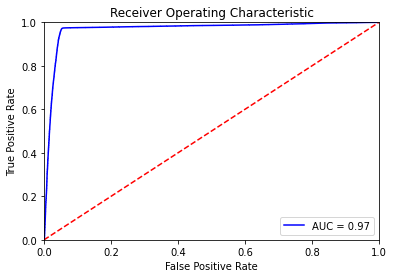

In [290]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#probs = model.predict_proba(x_t)
#preds = prob_churn_logit[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_t, prob_churn_logit)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [303]:
x['churn_TF']=y
x_t['churn_TF']=y_t
x_t

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,preferred_genre_other,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,churn_TF
22897,1,0.0,0.0,1.0,0.0,0.0,8,2,25.851492,25.0,...,0,0,1,0,0,0,0,0,0,0
123440,10,14.0,0.0,7.0,47.0,35.0,9,2,21.501623,45.0,...,0,0,0,1,0,0,0,0,0,1
84500,6,13.0,0.0,2.0,28.0,13.0,6,2,27.301448,20.0,...,0,0,0,0,0,0,0,1,0,1
33950,46,355.0,0.0,42.0,206.0,179.0,2,3,24.401536,46.0,...,0,0,1,0,0,0,0,0,0,0
93386,6,4.0,0.0,0.0,26.0,2.0,1,0,28.751405,34.0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82986,44,118.0,10.0,41.0,194.0,118.0,2,3,25.851492,28.0,...,0,1,1,0,0,0,0,0,0,0
113554,63,95.0,0.0,22.0,222.0,17.0,7,3,46.150880,58.0,...,0,0,0,0,0,1,0,0,0,0
61118,1,0.0,0.0,0.0,0.0,0.0,5,2,33.101274,32.0,...,0,0,0,0,0,0,0,1,0,1
46853,30,67.0,1.0,26.0,141.0,108.0,0,3,33.101274,60.0,...,0,0,1,0,0,0,0,0,0,0


In [304]:
xt_ind=x_t.index
xt_ind

Int64Index([ 22897, 123440,  84500,  33950,  93386, 102239,  80499,  39223,
             43567,  65893,
            ...
            132048, 102241,  21685,  10520,  31152,  82986, 113554,  61118,
             46853,  14133],
           dtype='int64', length=54008)

In [305]:


df_test=x_t.reset_index()
df_test.drop('index',axis=1,inplace=True)
df_test['prob_churn_rf']=pred[1]
#df_test['churn_TF']=
df_test

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,churn_TF,prob_churn_rf
0,1,0.0,0.0,1.0,0.0,0.0,8,2,25.851492,25.0,...,0,1,0,0,0,0,0,0,0,0.03
1,10,14.0,0.0,7.0,47.0,35.0,9,2,21.501623,45.0,...,0,0,1,0,0,0,0,0,1,0.99
2,6,13.0,0.0,2.0,28.0,13.0,6,2,27.301448,20.0,...,0,0,0,0,0,0,1,0,1,0.97
3,46,355.0,0.0,42.0,206.0,179.0,2,3,24.401536,46.0,...,0,1,0,0,0,0,0,0,0,0.04
4,6,4.0,0.0,0.0,26.0,2.0,1,0,28.751405,34.0,...,0,0,0,0,0,0,1,0,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54003,44,118.0,10.0,41.0,194.0,118.0,2,3,25.851492,28.0,...,1,1,0,0,0,0,0,0,0,0.17
54004,63,95.0,0.0,22.0,222.0,17.0,7,3,46.150880,58.0,...,0,0,0,0,1,0,0,0,0,0.04
54005,1,0.0,0.0,0.0,0.0,0.0,5,2,33.101274,32.0,...,0,0,0,0,0,0,1,0,1,0.98
54006,30,67.0,1.0,26.0,141.0,108.0,0,3,33.101274,60.0,...,0,1,0,0,0,0,0,0,0,0.03


In [306]:
def apply_offers2(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance
    #df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] <((discount_amount)))

    # make offer under logit predictions for select threshold
    df_f['make_offer_rf'] = (df_f['prob_churn_rf'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_rf'] = (df_f['make_offer_rf'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_rf_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_rf'], 'price_rf_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact


In [307]:
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'rf_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])


In [308]:
#suppose original prob=0.5
op=0.5
s1=0.3*0.5
s2=0.5*0.5
print(s1,s2)
#df_test['random_draws'] = np.random.random(df_test.shape[0])*discount_amount
#df_test

0.15 0.25


In [297]:
df_test

,total open,sum apps,num_videos_rated,num_series_started,num_videos_more_than_30_seconds,num_videos_completed,recency,cluster,weekly_consumption_hour,age,...,preferred_genre_regional,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,prob_churn_rf,random_draws
0,1,0.0,0.0,1.0,0.0,0.0,8,2,25.851492,25.0,...,0,1,0,0,0,0,0,0,0.03,0.174262
1,10,14.0,0.0,7.0,47.0,35.0,9,2,21.501623,45.0,...,0,0,1,0,0,0,0,0,0.99,0.525658
2,6,13.0,0.0,2.0,28.0,13.0,6,2,27.301448,20.0,...,0,0,0,0,0,0,1,0,0.97,0.867834
3,46,355.0,0.0,42.0,206.0,179.0,2,3,24.401536,46.0,...,0,1,0,0,0,0,0,0,0.04,0.773656
4,6,4.0,0.0,0.0,26.0,2.0,1,0,28.751405,34.0,...,0,0,0,0,0,0,1,0,0.89,0.282081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54003,44,118.0,10.0,41.0,194.0,118.0,2,3,25.851492,28.0,...,1,1,0,0,0,0,0,0,0.17,0.590142
54004,63,95.0,0.0,22.0,222.0,17.0,7,3,46.150880,58.0,...,0,0,0,0,1,0,0,0,0.04,0.386043
54005,1,0.0,0.0,0.0,0.0,0.0,5,2,33.101274,32.0,...,0,0,0,0,0,0,1,0,0.98,0.404386
54006,30,67.0,1.0,26.0,141.0,108.0,0,3,33.101274,60.0,...,0,1,0,0,0,0,0,0,0.03,0.985642


In [309]:
import copy

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers2(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers2(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

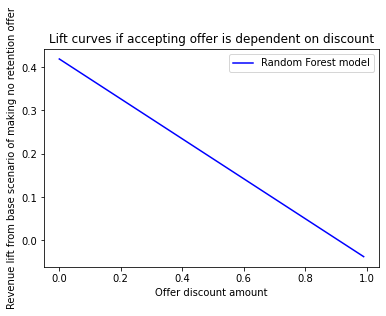

In [310]:

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['rf_offer'], 'b-')
#ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves if accepting offer is dependent on discount')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Random Forest model'])


In [311]:

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers2(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind


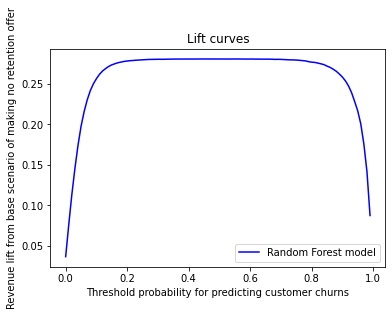

In [312]:

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['rf_offer'], 'b-')
#ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Random Forest model'])



In [313]:

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers2(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers2(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind



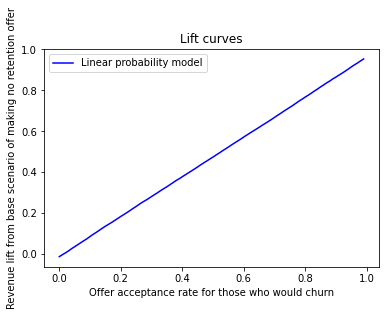

In [314]:

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['rf_offer'], 'b-')
#ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model'])


In [315]:
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    #df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] <((discount_amount)))

    # make offer under logit predictions for select threshold
    df_f['make_offer_rf'] = (df_f['prob_churn_rf'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_rf'] = (df_f['make_offer_rf'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_rf_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_rf'], 'price_rf_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact

In [316]:

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

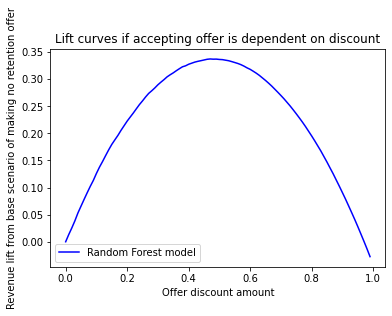

In [317]:

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['rf_offer'], 'b-')
#ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves if accepting offer is dependent on discount')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Random Forest model'])


In [945]:
#attribution

In [318]:
subs['attribution_survey'].value_counts()

facebook            119126
tv                   39904
referral             20882
search                8492
pinterest             7856
other                 6496
public_radio          6219
social_organic        3869
youtube               3108
podcast               2995
affiliate             1962
ott                   1443
sirius xm             1122
facebook_organic       765
direct_mail            408
amfm_radio             337
Name: attribution_survey, dtype: int64

In [319]:
subs['attribution_technical'].value_counts()

facebook                   80251
email                      25690
search                     25306
organic                    22013
brand sem intent google    18524
google_organic             10691
affiliate                   9894
email_blast                 7277
pinterest                   6065
referral                    5170
facebook_organic            3272
discovery                   2571
brand sem intent bing       2231
other                       1786
display                     1407
bing                        1146
internal                    1122
podcast                      985
youtube                      913
bing_organic                 369
vod                          297
ott                          158
direct_mail                  139
quora                        100
samsung                       86
appstore                      44
criteo                        44
pinterest_organic             30
influencer                    21
playstore                     12
content_gr

In [320]:
subs

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,0.0,False,2020-03-16,False,0.0000,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,1.0,False,2019-12-22,False,0.0000,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,0.0,False,2020-02-11,False,0.0000,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,9.0,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,comedy,supplement OTT,28.751405,1.905485,False,38.0,False,...,8.0,False,2019-12-02,False,0.0000,0.3303,ar,False,False,NaN
229587,25843074,enhanced,2.361370,comedy,replace OTT,27.301448,1.835189,True,49.0,False,...,NaN,True,2019-12-21,False,4.5875,0.3303,ar,True,False,Paypal
281340,24799085,base,NaN,comedy,access to exclusive content,31.651317,NaN,False,45.0,False,...,31.0,True,2020-01-05,True,0.0000,0.0367,ar,False,False,NaN
87198,21308040,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-01,False,NaN,NaN,ar,True,False,Paypal


In [321]:
cs=pd.read_csv('channel_spend_graduate.csv')

In [322]:
subs.columns

Index(['subid', 'package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'retarget_TF', 'age', 'male_TF',
       'country', 'attribution_technical', 'attribution_survey', 'op_sys',
       'months_per_bill_period', 'plan_type', 'monthly_price',
       'discount_price', 'account_creation_date', 'creation_until_cancel_days',
       'cancel_before_trial_end', 'trial_end_date',
       'initial_credit_card_declined', 'revenue_net', 'join_fee', 'language',
       'paid_TF', 'refund_after_trial_TF', 'payment_type'],
      dtype='object')

In [323]:
from datetime import datetime, timedelta
subs['month_yr'] = subs['account_creation_date'].apply(lambda x: x.strftime('%B-%Y')) 
subs['month_yr']
#cs['date'] = pd.to_datetime(cs['date'])

#cs['month_yr'] = pd.to_datetime(cs['date']).dt.strftime('%m')


cs['date']=cs['date'].apply(lambda x:str(x))
cs['month_yr']=cs['date'].apply(lambda x: datetime(year=int(x[0:4]), month=int(x[4:6]),day=10))


cs['month_yr']=cs['month_yr'].apply(lambda x: x.strftime('%B-%Y')) 
cs['month_yr']

0          July-2019
1          July-2019
2          July-2019
3          July-2019
4          July-2019
5        August-2019
6        August-2019
7        August-2019
8        August-2019
9        August-2019
10    September-2019
11    September-2019
12    September-2019
13    September-2019
14    September-2019
15      October-2019
16      October-2019
17      October-2019
18      October-2019
19      October-2019
20     November-2019
21     November-2019
22     November-2019
23     November-2019
24     November-2019
25     December-2019
26     December-2019
27     December-2019
28     December-2019
29     December-2019
30      January-2020
31      January-2020
32      January-2020
33      January-2020
34      January-2020
35     February-2020
36     February-2020
37     February-2020
38     February-2020
39     February-2020
Name: month_yr, dtype: object

In [324]:
date=subs.month_yr
date

162502     January-2020
380374       March-2020
496617    December-2019
356799     January-2020
681701     October-2019
              ...      
509326    November-2019
229587    December-2019
281340    December-2019
87198      January-2020
598241    November-2019
Name: month_yr, Length: 227628, dtype: object

In [325]:
cs

,channel,date,spend_AED,month_yr
0,bing,201907,400,July-2019
1,display,201907,12,July-2019
2,facebook,201907,9000,July-2019
3,search,201907,13000,July-2019
4,youtube,201907,90,July-2019
5,bing,201908,900,August-2019
6,display,201908,20,August-2019
7,facebook,201908,13000,August-2019
8,search,201908,18500,August-2019
9,youtube,201908,180,August-2019


In [326]:
l

[51583, 8129, 48644, 26663]

In [327]:
#spend=cs.loc[(cs['channel']=='facebook') ]
l=[]
spend=cs.loc[(cs['month_yr']=='August-2019') & (cs['channel']=='facebook') ]
aep=spend['spend_AED']
aep.to_list(l)
l

TypeError: tolist() takes 1 positional argument but 2 were given

In [329]:
d={}
cs2=cs.set_index('month_yr')
for i in cs['channel']:
    #print(i)
    somet=cs2.loc[cs2['channel']==i].drop('channel',axis=1).drop('date',axis=1)
    d[i]=somet
    
d

    

{'bing':                 spend_AED
 month_yr                 
 July-2019             400
 August-2019           900
 September-2019       1000
 October-2019         1100
 November-2019        1300
 December-2019         300
 January-2020         2100
 February-2020        3700,
 'display':                 spend_AED
 month_yr                 
 July-2019              12
 August-2019            20
 September-2019         13
 October-2019           19
 November-2019          29
 December-2019          31
 January-2020          148
 February-2020          94,
 'facebook':                 spend_AED
 month_yr                 
 July-2019            9000
 August-2019         13000
 September-2019      10500
 October-2019        17000
 November-2019       23000
 December-2019       16000
 January-2020        11000
 February-2020       14000,
 'search':                 spend_AED
 month_yr                 
 July-2019           13000
 August-2019         18500
 September-2019      19000
 October-20

In [330]:
d['bing'].index

Index(['July-2019', 'August-2019', 'September-2019', 'October-2019',
       'November-2019', 'December-2019', 'January-2020', 'February-2020'],
      dtype='object', name='month_yr')

In [331]:
tec={'facebook':[] ,'email':[] ,'search':[] ,'organic':[] ,'brand sem intent google':[] ,'google_organic':[] ,'affiliate':[] ,'email_blast':[] ,'pinterest':[] ,'referral':[] ,
 'facebook_organic':[] ,'discovery':[] ,'brand sem intent bing':[] ,'other':[] ,'display':[] ,
 'bing':[] ,'internal':[] ,'podcast':[] ,'youtube':[] ,'bing_organic':[] ,'vod':[] ,'ott':[] ,'direct_mail':[] ,'quora':[] ,'samsung':[] ,
 'criteo':[] ,'appstore':[] ,'pinterest_organic':[] ,'influencer':[] ,'playstore':[] ,'twitter':[] ,'content_greatist':[] ,'tv':[]}


ft={'facebook':[],'tv':[],'search':[],'pinterest':[],'other':[],'public_radio':[],'social_organic':[],
   'youtube':[],'podcast':[],'affiliate':[],'ott':[],'sirius xm':[],'facebook_organic':[],
    'direct_mail':[],'amfm_radio':[],'referral':[],'nothing':[]}




In [332]:
for i in ft:
    ft[i]={'July-2019':[],'August-2019':[],'September-2019':[],
           'October-2019':[],'November-2019':[],'December-2019':[],
           'January-2020':[], 'February-2020':[]}

In [333]:
for i in tec:
    tec[i]={'July-2019':[],'August-2019':[],'September-2019':[],
           'October-2019':[],'November-2019':[],'December-2019':[],
           'January-2020':[], 'February-2020':[]}

In [334]:
subs['attribution_survey'].fillna('nothing',inplace=True)
subs.attribution_survey.isnull().sum()

0

In [336]:
#attribution modelling
flag=0
l=[]
for i in subs.index:
    att_lt=subs.loc[i].attribution_technical
    att_ft=subs.loc[i].attribution_survey
    date=subs.loc[i].month_yr

  #  try:
   #     spend_aed=d[att_lt].loc[date]        
   # except:
    #    spend_aed=0
    
    
    if date in tec[att_lt]:
        
        tec[att_lt][date].append(1)
    else:
        tec[att_lt][date]=[1]
    if date in ft[att_ft]:
        #    print(ft[att_ft])
        ft[att_ft][date].append(1)
    else:
        ft[att_ft][date]=[1]

    #tec[att_lt][date].append(1)
   # flag+=1
    #if flag==10:
     #break
#tec

In [337]:
sum(ft['youtube']['July-2019'])

85

In [338]:
dates=tec['facebook'].keys()
dates

dict_keys(['July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019', 'January-2020', 'February-2020', 'March-2020', 'June-2019'])

In [339]:
cs2.loc[cs2['channel']=='bing'].loc['July-2019']

channel        bing
date         201907
spend_AED       400
Name: July-2019, dtype: object

In [340]:
tec.keys()


dict_keys(['facebook', 'email', 'search', 'organic', 'brand sem intent google', 'google_organic', 'affiliate', 'email_blast', 'pinterest', 'referral', 'facebook_organic', 'discovery', 'brand sem intent bing', 'other', 'display', 'bing', 'internal', 'podcast', 'youtube', 'bing_organic', 'vod', 'ott', 'direct_mail', 'quora', 'samsung', 'criteo', 'appstore', 'pinterest_organic', 'influencer', 'playstore', 'twitter', 'content_greatist', 'tv'])

In [341]:
dic={}
dic2={}
tec.keys()
for i in tec.keys():
    fac=[]
    #print(i)
    for i2 in dates:
        #print(i,i2)
        try:
            fac.append(sum(tec[i][i2]))

            #print(sum(tec[i][i2]),i,i2)
        except:
            #print('no such date')
            pass
    dic[i]=fac
    #print(fac,i)
for i in ft.keys():
    fac=[]
    #print(i)
    for i2 in dates:
        #print(i,i2)
        try:
            fac.append(sum(ft[i][i2]))
            #print(sum(tec[i][i2]),i,i2)
        except:
            #print('no such date')
            pass
    dic2[i]=fac
    #print(fac,i)

In [342]:
att={}
n=len(subs)
for i in dic:
   # print(sum(dic[i]),i)
    att[i]=sum(dic[i])/n
att_ft={}
for i in dic2:
    att_ft[i]=sum(dic2[i])/n

In [343]:
att_ft

{'facebook': 0.5233363206635387,
 'tv': 0.17530356546646284,
 'search': 0.037306482506545766,
 'pinterest': 0.034512450137944364,
 'other': 0.0285377897270986,
 'public_radio': 0.02732089198165428,
 'social_organic': 0.016997030242325198,
 'youtube': 0.013653856291844589,
 'podcast': 0.013157432301825787,
 'affiliate': 0.008619326269176024,
 'ott': 0.006339290421213559,
 'sirius xm': 0.004929094838947757,
 'facebook_organic': 0.0033607464811007434,
 'direct_mail': 0.0017923981232537299,
 'amfm_radio': 0.0014804857047463404,
 'referral': 0.0917373961024127,
 'nothing': 0.011615442739908974}

In [344]:
att.keys()

dict_keys(['facebook', 'email', 'search', 'organic', 'brand sem intent google', 'google_organic', 'affiliate', 'email_blast', 'pinterest', 'referral', 'facebook_organic', 'discovery', 'brand sem intent bing', 'other', 'display', 'bing', 'internal', 'podcast', 'youtube', 'bing_organic', 'vod', 'ott', 'direct_mail', 'quora', 'samsung', 'criteo', 'appstore', 'pinterest_organic', 'influencer', 'playstore', 'twitter', 'content_greatist', 'tv'])

In [345]:
att_ft['facebook']

0.5233363206635387

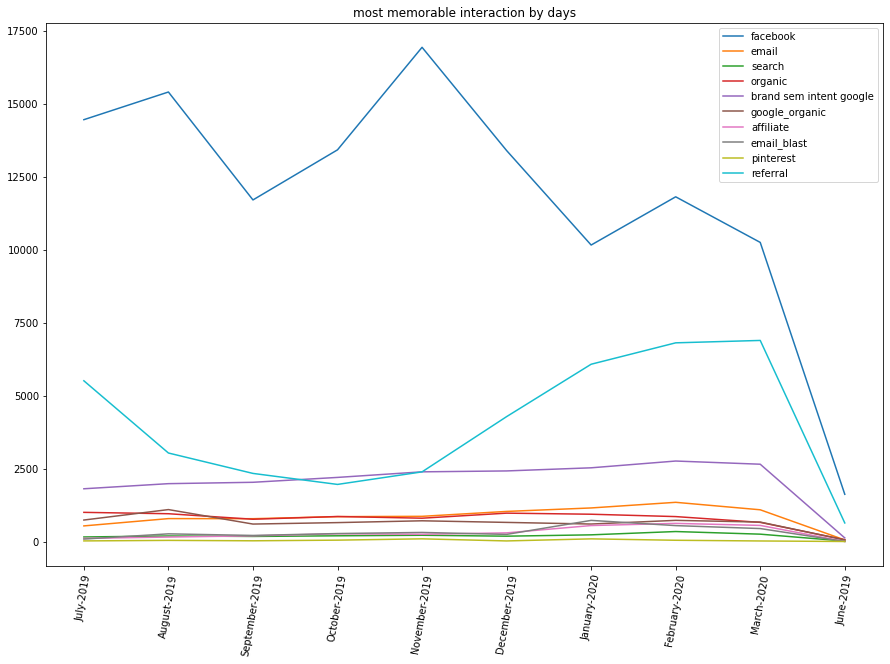

In [346]:
#attribution plot
figure(figsize=(15,10))
for i in dic.keys():
    try:
        plt.plot(dates,dic2[i])
        plt.xticks(rotation=80)
    except:
        pass
plt.title('most memorable interaction by days')
plt.legend(dic.keys())
plt.show()
    

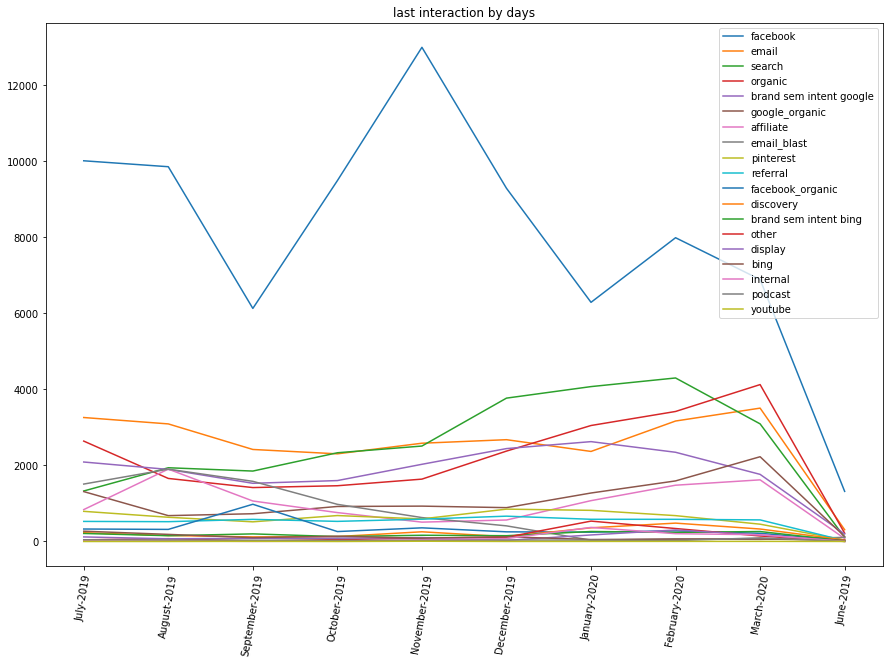

In [347]:
#attribution plot
figure(figsize=(15,10))
for i in dic.keys():
    try:
        plt.plot(dates,dic[i])
        plt.xticks(rotation=80)
    except:
        pass
plt.title('last interaction by days')
plt.legend(dic.keys())
plt.show()
    

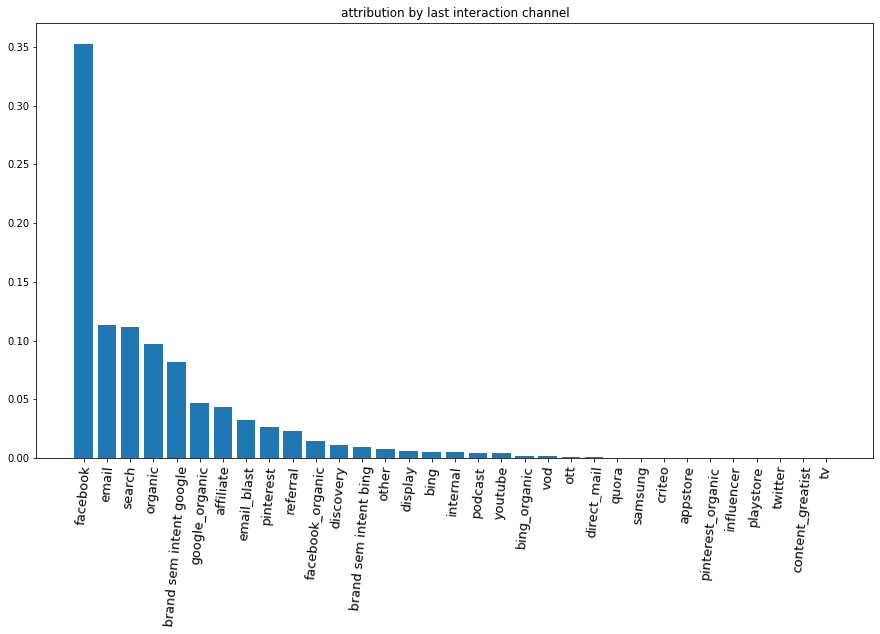

In [348]:
figure(figsize=(15,8))
plt.title('attribution by last interaction channel')
plt.bar(att.keys(),att.values())
plt.xticks(rotation=85,fontsize=13)
plt.show()

In [349]:
sorted(att_ft)

['affiliate',
 'amfm_radio',
 'direct_mail',
 'facebook',
 'facebook_organic',
 'nothing',
 'other',
 'ott',
 'pinterest',
 'podcast',
 'public_radio',
 'referral',
 'search',
 'sirius xm',
 'social_organic',
 'tv',
 'youtube']

In [350]:
att_ft

{'facebook': 0.5233363206635387,
 'tv': 0.17530356546646284,
 'search': 0.037306482506545766,
 'pinterest': 0.034512450137944364,
 'other': 0.0285377897270986,
 'public_radio': 0.02732089198165428,
 'social_organic': 0.016997030242325198,
 'youtube': 0.013653856291844589,
 'podcast': 0.013157432301825787,
 'affiliate': 0.008619326269176024,
 'ott': 0.006339290421213559,
 'sirius xm': 0.004929094838947757,
 'facebook_organic': 0.0033607464811007434,
 'direct_mail': 0.0017923981232537299,
 'amfm_radio': 0.0014804857047463404,
 'referral': 0.0917373961024127,
 'nothing': 0.011615442739908974}

In [351]:
print(sorted(att_ft.values()),sorted(att_ft.keys()))

[0.0014804857047463404, 0.0017923981232537299, 0.0033607464811007434, 0.004929094838947757, 0.006339290421213559, 0.008619326269176024, 0.011615442739908974, 0.013157432301825787, 0.013653856291844589, 0.016997030242325198, 0.02732089198165428, 0.0285377897270986, 0.034512450137944364, 0.037306482506545766, 0.0917373961024127, 0.17530356546646284, 0.5233363206635387] ['affiliate', 'amfm_radio', 'direct_mail', 'facebook', 'facebook_organic', 'nothing', 'other', 'ott', 'pinterest', 'podcast', 'public_radio', 'referral', 'search', 'sirius xm', 'social_organic', 'tv', 'youtube']


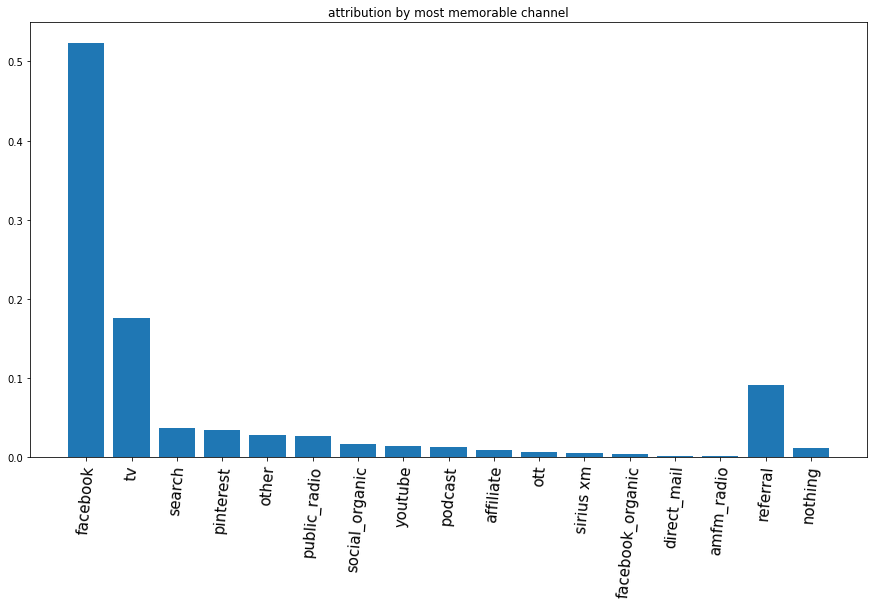

In [352]:
figure(figsize=(15,8))
plt.title('attribution by most memorable channel')
plt.bar(att_ft.keys(),(att_ft.values()))
plt.xticks(rotation=85,fontsize=15)
plt.show()

In [354]:
#cac:
cac={}
for i in att.keys():
    new_cust=att[i]*n
    print(new_cust,i)
cac_ft={}
for i in att_ft.keys():
    new_cust=att_ft[i]*n
    
    
'''    
    if i not in ['direct','organic_search']:
        cost=6000  #what is cost?
    else:
        cost=0
    cac=cost/new_cust
    dic_ft[i]=cac
    print(i,cac)'''

80251.0 facebook
25690.0 email
25306.0 search
22013.0 organic
18524.0 brand sem intent google
10691.0 google_organic
9894.0 affiliate
7276.999999999999 email_blast
6065.0 pinterest
5170.0 referral
3272.0 facebook_organic
2571.0 discovery
2231.0 brand sem intent bing
1786.0 other
1407.0 display
1146.0 bing
1122.0 internal
985.0 podcast
913.0 youtube
369.0 bing_organic
297.0 vod
158.0 ott
139.0 direct_mail
100.0 quora
86.0 samsung
44.0 criteo
44.0 appstore
30.0 pinterest_organic
21.0 influencer
12.0 playstore
5.0 twitter
5.0 content_greatist
4.0 tv


"    \n    if i not in ['direct','organic_search']:\n        cost=6000  #what is cost?\n    else:\n        cost=0\n    cac=cost/new_cust\n    dic_ft[i]=cac\n    print(i,cac)"

In [355]:
len(dates)

10

In [356]:
date=list(dates)
date

['July-2019',
 'August-2019',
 'September-2019',
 'October-2019',
 'November-2019',
 'December-2019',
 'January-2020',
 'February-2020',
 'March-2020',
 'June-2019']

In [357]:
att.keys()

dict_keys(['facebook', 'email', 'search', 'organic', 'brand sem intent google', 'google_organic', 'affiliate', 'email_blast', 'pinterest', 'referral', 'facebook_organic', 'discovery', 'brand sem intent bing', 'other', 'display', 'bing', 'internal', 'podcast', 'youtube', 'bing_organic', 'vod', 'ott', 'direct_mail', 'quora', 'samsung', 'criteo', 'appstore', 'pinterest_organic', 'influencer', 'playstore', 'twitter', 'content_greatist', 'tv'])

In [358]:
dic

{'facebook': [10011, 9855, 6129, 9489, 12995, 9288, 6289, 7988, 6889, 1318],
 'email': [3260, 3092, 2420, 2305, 2584, 2677, 2368, 3168, 3507, 309],
 'search': [1328, 1939, 1852, 2333, 2510, 3770, 4073, 4300, 3093, 108],
 'organic': [2640, 1658, 1418, 1466, 1640, 2377, 3050, 3419, 4126, 219],
 'brand sem intent google': [2090,
  1895,
  1530,
  1602,
  2030,
  2443,
  2626,
  2346,
  1765,
  197],
 'google_organic': [1312, 680, 730, 921, 930, 890, 1275, 1593, 2229, 131],
 'affiliate': [839, 1903, 1065, 760, 509, 565, 1074, 1480, 1621, 78],
 'email_blast': [1510, 1902, 1582, 977, 629, 411, 35, 66, 56, 109],
 'pinterest': [793, 637, 517, 682, 594, 851, 819, 680, 455, 37],
 'referral': [528, 521, 582, 529, 587, 666, 584, 583, 568, 22],
 'facebook_organic': [328, 318, 979, 261, 359, 254, 245, 280, 215, 33],
 'discovery': [0, 265, 688, 400, 503, 341, 233, 91, 50],
 'brand sem intent bing': [231, 158, 120, 130, 255, 126, 360, 483, 328, 40],
 'other': [211, 152, 200, 129, 164, 152, 263, 239, 2

In [359]:
cacs={}
cacs_free={}
for i in date:
    cacs[i]={}
    cacs_free[i]={}
print(cacs)


cacs_ft={}
cacs_ft_free={}
for i in date:
    cacs_ft[i]={}
    cacs_ft_free={}


{'July-2019': {}, 'August-2019': {}, 'September-2019': {}, 'October-2019': {}, 'November-2019': {}, 'December-2019': {}, 'January-2020': {}, 'February-2020': {}, 'March-2020': {}, 'June-2019': {}}


In [360]:
for i in att.keys():
    #print(att[i])
    new_cust=n*att[i]
    flag=0
    for i2 in dic[i]:
        #print(i2,i)
        #print(date[flag])
        try:
            sp=cs2.loc[cs2['channel']==i].loc[date[flag]]
            #print(sp['spend_AED']/new_cust)
            cac=sp['spend_AED']/new_cust
            #print(cac,i,date[flag])
            cacs[date[flag]][i]=cac
            cacs_free[date[flag]][i]=cac
        except:
            #print(i,0,date[flag])
            cacs_free[date[flag]][i]=0
        flag+=1
cacs

{'July-2019': {'facebook': 0.11214813522572928,
  'search': 0.51371216312337,
  'display': 0.008528784648187633,
  'bing': 0.34904013961605584,
  'youtube': 0.09857612267250822},
 'August-2019': {'facebook': 0.16199175088160894,
  'search': 0.7310519244447957,
  'display': 0.014214641080312722,
  'bing': 0.7853403141361257,
  'youtube': 0.19715224534501644},
 'September-2019': {'facebook': 0.13083949109668416,
  'search': 0.7508100845649253,
  'display': 0.00923951670220327,
  'bing': 0.8726003490401396,
  'youtube': 0.10952902519167579},
 'October-2019': {'facebook': 0.21183536653748863,
  'search': 0.9483916857662215,
  'display': 0.013503909026297086,
  'bing': 0.9598603839441536,
  'youtube': 0.14238773274917854},
 'November-2019': {'facebook': 0.28660079002130817,
  'search': 0.9879080060064807,
  'display': 0.02061122956645345,
  'bing': 1.1343804537521816,
  'youtube': 0.6024096385542169},
 'December-2019': {'facebook': 0.1993744626235187,
  'search': 1.5016201691298505,
  'disp

In [361]:
for i in att_ft.keys():
    #print(att[i])
    new_cust=n*att_ft[i]
    flag=0
    for i2 in dic2[i]:
        #print(i2,i)
        #print(date[flag])
        try:
            sp=cs2.loc[cs2['channel']==i].loc[date[flag]]
            #print(sp['spend_AED']/new_cust)
            cac=sp['spend_AED']/new_cust
            #print(cac,i,date[flag])
            cacs_ft[date[flag]][i]=cac
            cacs_ft_free[date[flag]][i]=cac
        except:
            #print(i,0,date[flag])
            pass
            #cacs_ft_free[date[flag]][i]=0
        flag+=1

In [362]:
cacs_ft

{'July-2019': {'facebook': 0.07555025771032352,
  'search': 1.5308525671219972,
  'youtube': 0.02895752895752896},
 'August-2019': {'facebook': 0.10912815002602287,
  'search': 2.1785209609043807,
  'youtube': 0.05791505791505792},
 'September-2019': {'facebook': 0.08814196732871078,
  'search': 2.237399905793688,
  'youtube': 0.032175032175032175},
 'October-2019': {'facebook': 0.1427060423417222,
  'search': 2.826189354686764,
  'youtube': 0.04182754182754183},
 'November-2019': {'facebook': 0.19307288081527121,
  'search': 2.943947244465379,
  'youtube': 0.17696267696267695},
 'December-2019': {'facebook': 0.1343115692627974,
  'search': 4.474799811587376,
  'youtube': 0.28957528957528955},
 'January-2020': {'facebook': 0.0923392038681732,
  'search': 4.828073480923222,
  'youtube': 1.4028314028314028},
 'February-2020': {'facebook': 0.1175226231049477,
  'search': 5.181347150259067,
  'youtube': 0.7786357786357786},
 'March-2020': {},
 'June-2019': {}}

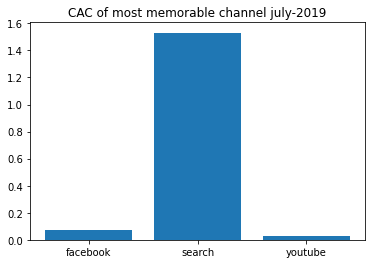

In [363]:
plt.title('CAC of most memorable channel july-2019')
plt.bar(cacs_ft['July-2019'].keys() ,cacs_ft['July-2019'].values() )
plt.show()

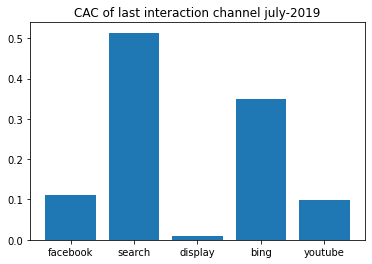

In [364]:
# cacs['July-2019'].keys()
plt.title('CAC of last interaction channel july-2019')

plt.bar(cacs['July-2019'].keys() ,cacs['July-2019'].values() )
plt.show()

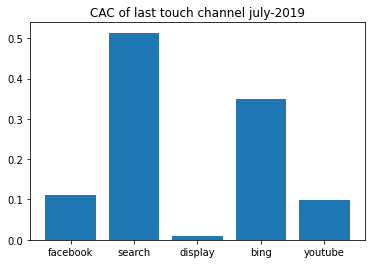

In [366]:
plt.title('CAC of last touch channel july-2019')
plt.bar(cacs['July-2019'].keys() ,cacs['July-2019'].values() )
plt.show()

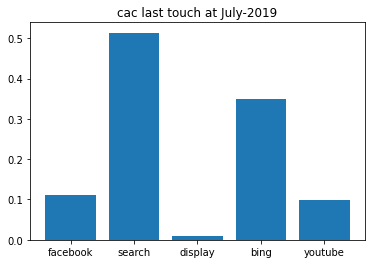

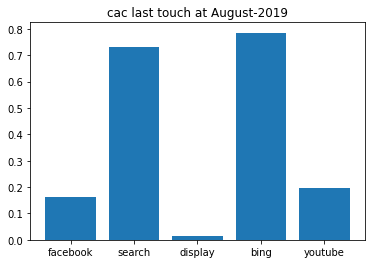

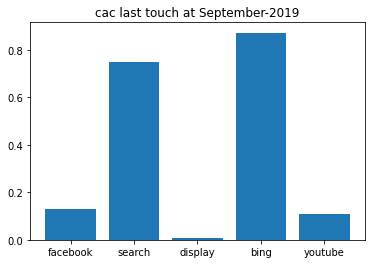

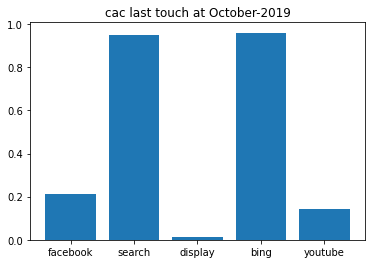

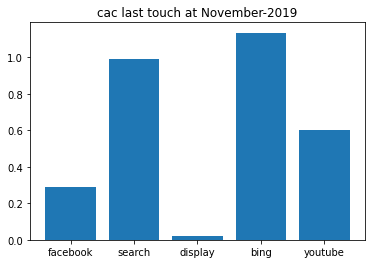

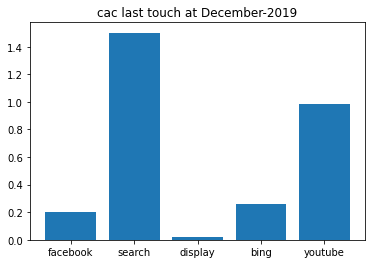

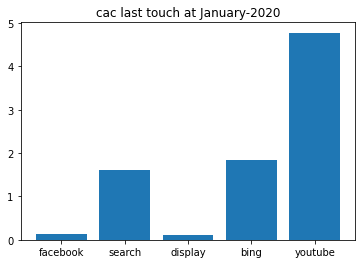

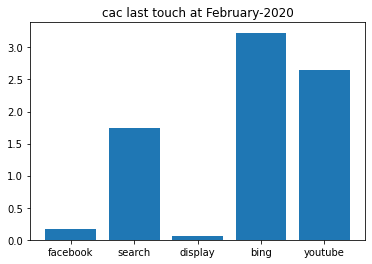

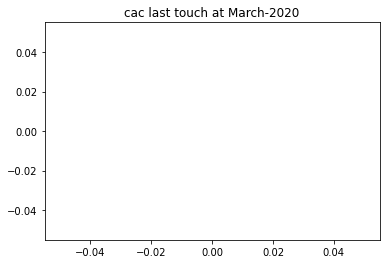

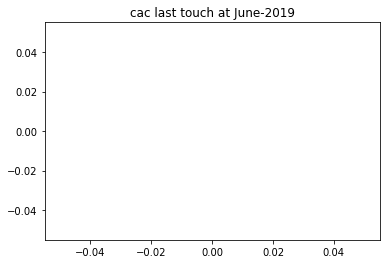

In [367]:
#figure(figsize=(10,10))

for i in dates:
    tit='cac last touch at '+i
    plt.title(tit)

    plt.bar(cacs[i].keys() ,cacs[i].values() )

#plt.legend(dates)
#plt.title('CAC by months')
    plt.show()

In [368]:
list(cs['channel'].unique())

['bing', 'display', 'facebook', 'search', 'youtube']

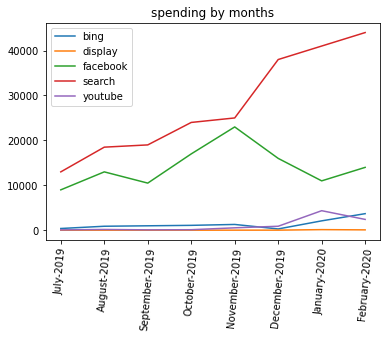

In [369]:
xs=[]
plt.title('spending by months')
for i in list(cs['channel'].unique()):
    y=cs.loc[cs['channel']==i]['spend_AED']
    x=cs.loc[cs['channel']==i]['month_yr']
    xs.append(x)
    plt.plot(x,y)
plt.legend(cs['channel'].unique())
plt.xticks(rotation=85)
plt.show()

In [370]:
xs

[0          July-2019
 5        August-2019
 10    September-2019
 15      October-2019
 20     November-2019
 25     December-2019
 30      January-2020
 35     February-2020
 Name: month_yr, dtype: object,
 1          July-2019
 6        August-2019
 11    September-2019
 16      October-2019
 21     November-2019
 26     December-2019
 31      January-2020
 36     February-2020
 Name: month_yr, dtype: object,
 2          July-2019
 7        August-2019
 12    September-2019
 17      October-2019
 22     November-2019
 27     December-2019
 32      January-2020
 37     February-2020
 Name: month_yr, dtype: object,
 3          July-2019
 8        August-2019
 13    September-2019
 18      October-2019
 23     November-2019
 28     December-2019
 33      January-2020
 38     February-2020
 Name: month_yr, dtype: object,
 4          July-2019
 9        August-2019
 14    September-2019
 19      October-2019
 24     November-2019
 29     December-2019
 34      January-2020
 39     Februa

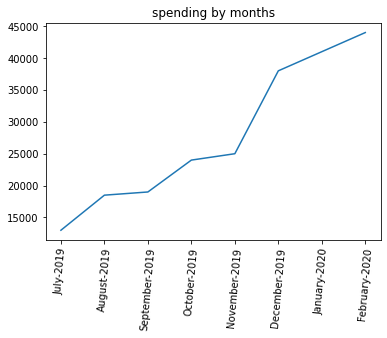

In [371]:
y=cs.loc[cs['channel']=='search']['spend_AED']
x=cs.loc[cs['channel']=='search']['month_yr']

plt.title('spending by months')
plt.plot(x,y)
plt.xticks(rotation=85)
plt.show()

In [372]:
cacs_ft

{'July-2019': {'facebook': 0.07555025771032352,
  'search': 1.5308525671219972,
  'youtube': 0.02895752895752896},
 'August-2019': {'facebook': 0.10912815002602287,
  'search': 2.1785209609043807,
  'youtube': 0.05791505791505792},
 'September-2019': {'facebook': 0.08814196732871078,
  'search': 2.237399905793688,
  'youtube': 0.032175032175032175},
 'October-2019': {'facebook': 0.1427060423417222,
  'search': 2.826189354686764,
  'youtube': 0.04182754182754183},
 'November-2019': {'facebook': 0.19307288081527121,
  'search': 2.943947244465379,
  'youtube': 0.17696267696267695},
 'December-2019': {'facebook': 0.1343115692627974,
  'search': 4.474799811587376,
  'youtube': 0.28957528957528955},
 'January-2020': {'facebook': 0.0923392038681732,
  'search': 4.828073480923222,
  'youtube': 1.4028314028314028},
 'February-2020': {'facebook': 0.1175226231049477,
  'search': 5.181347150259067,
  'youtube': 0.7786357786357786},
 'March-2020': {},
 'June-2019': {}}

In [373]:
mc=pd.DataFrame(cacs_ft).T
mc

,facebook,search,youtube
July-2019,0.075550,1.530853,0.028958
August-2019,0.109128,2.178521,0.057915
September-2019,0.088142,2.237400,0.032175
October-2019,0.142706,2.826189,0.041828
November-2019,0.193073,2.943947,0.176963
December-2019,0.134312,4.474800,0.289575
January-2020,0.092339,4.828073,1.402831
February-2020,0.117523,5.181347,0.778636
March-2020,NaN,NaN,NaN
June-2019,NaN,NaN,NaN


In [374]:
mc2=pd.DataFrame(cacs).T
mc2

,facebook,search,display,bing,youtube
July-2019,0.112148,0.513712,0.008529,0.349040,0.098576
August-2019,0.161992,0.731052,0.014215,0.785340,0.197152
September-2019,0.130839,0.750810,0.009240,0.872600,0.109529
October-2019,0.211835,0.948392,0.013504,0.959860,0.142388
November-2019,0.286601,0.987908,0.020611,1.134380,0.602410
December-2019,0.199374,1.501620,0.022033,0.261780,0.985761
January-2020,0.137070,1.620169,0.105188,1.832461,4.775465
February-2020,0.174453,1.738718,0.066809,3.228621,2.650602
March-2020,NaN,NaN,NaN,NaN,NaN
June-2019,NaN,NaN,NaN,NaN,NaN


In [375]:
cs.loc[cs['channel']=='facebook']['spend_AED']

2      9000
7     13000
12    10500
17    17000
22    23000
27    16000
32    11000
37    14000
Name: spend_AED, dtype: int64

In [376]:
d={}
for i in ['facebook','search','display','display','bing','youtube']:
    df1=cs.loc[cs['channel']==i]['spend_AED']
    d[i]=df1
d

{'facebook': 2      9000
 7     13000
 12    10500
 17    17000
 22    23000
 27    16000
 32    11000
 37    14000
 Name: spend_AED, dtype: int64,
 'search': 3     13000
 8     18500
 13    19000
 18    24000
 23    25000
 28    38000
 33    41000
 38    44000
 Name: spend_AED, dtype: int64,
 'display': 1      12
 6      20
 11     13
 16     19
 21     29
 26     31
 31    148
 36     94
 Name: spend_AED, dtype: int64,
 'bing': 0      400
 5      900
 10    1000
 15    1100
 20    1300
 25     300
 30    2100
 35    3700
 Name: spend_AED, dtype: int64,
 'youtube': 4       90
 9      180
 14     100
 19     130
 24     550
 29     900
 34    4360
 39    2420
 Name: spend_AED, dtype: int64}

In [377]:
d['display']

1      12
6      20
11     13
16     19
21     29
26     31
31    148
36     94
Name: spend_AED, dtype: int64

In [378]:
spending=pd.DataFrame(d['facebook'])
spending.reset_index(inplace=True)
spending.drop('index',axis=1,inplace=True)
spending

,spend_AED
0,9000
1,13000
2,10500
3,17000
4,23000
5,16000
6,11000
7,14000


In [379]:
for i in d.keys():
    df2=pd.DataFrame(d[i])
    df2.reset_index(inplace=True)
    df2.drop('index',axis=1,inplace=True)
    spending[i]=df2['spend_AED']
    
spending

,spend_AED,facebook,search,display,bing,youtube
0,9000,9000,13000,12,400,90
1,13000,13000,18500,20,900,180
2,10500,10500,19000,13,1000,100
3,17000,17000,24000,19,1100,130
4,23000,23000,25000,29,1300,550
5,16000,16000,38000,31,300,900
6,11000,11000,41000,148,2100,4360
7,14000,14000,44000,94,3700,2420


In [380]:
spending=spending.drop('spend_AED',axis=1)
spending

,facebook,search,display,bing,youtube
0,9000,13000,12,400,90
1,13000,18500,20,900,180
2,10500,19000,13,1000,100
3,17000,24000,19,1100,130
4,23000,25000,29,1300,550
5,16000,38000,31,300,900
6,11000,41000,148,2100,4360
7,14000,44000,94,3700,2420


In [381]:
mc2

,facebook,search,display,bing,youtube
July-2019,0.112148,0.513712,0.008529,0.349040,0.098576
August-2019,0.161992,0.731052,0.014215,0.785340,0.197152
September-2019,0.130839,0.750810,0.009240,0.872600,0.109529
October-2019,0.211835,0.948392,0.013504,0.959860,0.142388
November-2019,0.286601,0.987908,0.020611,1.134380,0.602410
December-2019,0.199374,1.501620,0.022033,0.261780,0.985761
January-2020,0.137070,1.620169,0.105188,1.832461,4.775465
February-2020,0.174453,1.738718,0.066809,3.228621,2.650602
March-2020,NaN,NaN,NaN,NaN,NaN
June-2019,NaN,NaN,NaN,NaN,NaN


In [382]:
mc2

,facebook,search,display,bing,youtube
July-2019,0.112148,0.513712,0.008529,0.349040,0.098576
August-2019,0.161992,0.731052,0.014215,0.785340,0.197152
September-2019,0.130839,0.750810,0.009240,0.872600,0.109529
October-2019,0.211835,0.948392,0.013504,0.959860,0.142388
November-2019,0.286601,0.987908,0.020611,1.134380,0.602410
December-2019,0.199374,1.501620,0.022033,0.261780,0.985761
January-2020,0.137070,1.620169,0.105188,1.832461,4.775465
February-2020,0.174453,1.738718,0.066809,3.228621,2.650602
March-2020,NaN,NaN,NaN,NaN,NaN
June-2019,NaN,NaN,NaN,NaN,NaN


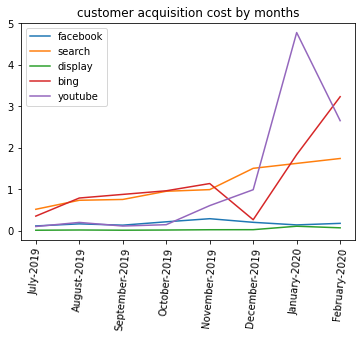

In [383]:
plt.title('customer acquisition cost by months')
for i in mc2.columns:
    plt.plot(mc2.index, mc2[i])
plt.legend(mc2.columns)
plt.xticks(rotation=85)
plt.show()

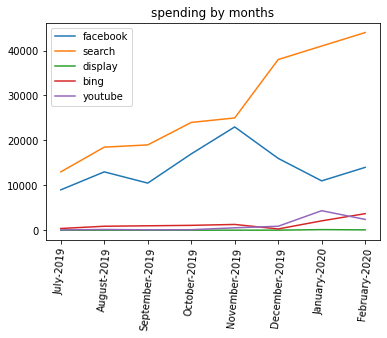

In [384]:
plt.title('spending by months')
for i in spending.columns:
    plt.plot(mc2.index[0:8],spending[i])
plt.legend(spending.columns)
plt.xticks(rotation=85)
plt.show()

In [385]:
cs['channel'].unique()

array(['bing', 'display', 'facebook', 'search', 'youtube'], dtype=object)

In [386]:
cs2.loc[cs2['channel']=='facebook']

,channel,date,spend_AED
month_yr,,,
July-2019,facebook,201907,9000
August-2019,facebook,201908,13000
September-2019,facebook,201909,10500
October-2019,facebook,201910,17000
November-2019,facebook,201911,23000
December-2019,facebook,201912,16000
January-2020,facebook,202001,11000
February-2020,facebook,202002,14000


In [387]:
fb=subs.loc[subs['attribution_survey']=='facebook']
se=subs.loc[subs['attribution_survey']=='search']
dis=subs.loc[subs['attribution_survey']=='display']
bi=subs.loc[subs['attribution_survey']=='bing']
you=subs.loc[subs['attribution_survey']=='youtube']
you

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type,month_yr
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,False,2019-10-20,False,0.0000,0.0367,ar,False,False,NaN,October-2019
389385,23676530,base,NaN,comedy,access to exclusive content,24.401536,NaN,False,21.0,False,...,False,2020-03-24,False,0.0000,0.3303,ar,False,False,NaN,March-2020
420126,29615706,enhanced,2.626477,regional,access to exclusive content,25.851492,1.952461,False,61.0,False,...,False,2019-11-24,False,0.0000,0.0367,ar,False,False,NaN,November-2019
424876,20344399,enhanced,2.405557,comedy,replace OTT,22.951579,1.985311,False,32.0,False,...,False,2020-01-27,False,0.0000,0.6606,ar,False,False,NaN,January-2020
273812,28886107,enhanced,NaN,comedy,access to exclusive content,22.951579,NaN,False,52.0,False,...,True,2020-03-02,False,4.8444,0.0367,ar,True,False,Paypal,February-2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210175,29683538,enhanced,2.636787,comedy,access to exclusive content,25.851492,1.891734,False,46.0,False,...,True,2019-10-02,False,4.9178,0.0367,ar,True,False,Standard Charter,September-2019
483619,28333296,base,4.688424,comedy,replace OTT,24.401536,2.407563,False,26.0,False,...,False,2020-02-05,False,0.0000,0.3303,ar,False,False,NaN,January-2020
206905,23236431,economy,2.511600,comedy,other,25.851492,1.836356,False,34.0,False,...,True,2020-02-08,False,0.0000,0.3303,ar,True,True,Paypal,January-2020
435818,20490713,base,NaN,comedy,access to exclusive content,30.201361,NaN,False,22.0,False,...,True,2020-02-23,True,0.0000,0.0000,ar,False,False,NaN,February-2020


In [388]:
def find_newcust(you):
    new_cust=[]
    for i in mc2.index:
        #print(i)
        subsection=you.loc[you['month_yr']==i]
        #print(len(subsection),i)
        new_cust.append(len(subsection))
    return(new_cust)


In [389]:
fbnc=find_newcust(fb)
senc=find_newcust(se)
dinc=find_newcust(dis)
binc=find_newcust(bi)
yonc=find_newcust(you)
yonc

[85, 264, 209, 274, 312, 245, 725, 546, 445, 3]

In [390]:
dinc

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [391]:
att_ft.keys()

dict_keys(['facebook', 'tv', 'search', 'pinterest', 'other', 'public_radio', 'social_organic', 'youtube', 'podcast', 'affiliate', 'ott', 'sirius xm', 'facebook_organic', 'direct_mail', 'amfm_radio', 'referral', 'nothing'])

In [392]:
att.keys()

dict_keys(['facebook', 'email', 'search', 'organic', 'brand sem intent google', 'google_organic', 'affiliate', 'email_blast', 'pinterest', 'referral', 'facebook_organic', 'discovery', 'brand sem intent bing', 'other', 'display', 'bing', 'internal', 'podcast', 'youtube', 'bing_organic', 'vod', 'ott', 'direct_mail', 'quora', 'samsung', 'criteo', 'appstore', 'pinterest_organic', 'influencer', 'playstore', 'twitter', 'content_greatist', 'tv'])

In [393]:
dic2

{'facebook': [14451,
  15399,
  11702,
  13418,
  16930,
  13394,
  10157,
  11809,
  10247,
  1619],
 'tv': [5507, 3033, 2334, 1957, 2387, 4279, 6074, 6807, 6889, 637],
 'search': [536, 786, 783, 853, 864, 1032, 1151, 1344, 1088, 55],
 'pinterest': [1000, 953, 764, 858, 800, 973, 936, 855, 657, 60],
 'other': [737, 1095, 599, 649, 711, 656, 600, 726, 667, 56],
 'public_radio': [508, 784, 723, 906, 845, 788, 583, 597, 477, 8],
 'social_organic': [392, 488, 390, 456, 470, 431, 386, 441, 373, 42],
 'youtube': [85, 264, 209, 274, 312, 245, 725, 546, 445, 3],
 'podcast': [108, 154, 196, 266, 249, 297, 548, 622, 553, 2],
 'affiliate': [157, 191, 175, 197, 216, 184, 230, 343, 253, 16],
 'ott': [0, 1, 0, 5, 116, 147, 187, 482, 505],
 'sirius xm': [3, 100, 123, 153, 131, 110, 151, 186, 165],
 'facebook_organic': [2, 0, 2, 2, 135, 154, 146, 157, 167],
 'direct_mail': [22, 40, 26, 48, 93, 21, 92, 44, 20, 2],
 'amfm_radio': [0, 0, 0, 0, 0, 0, 91, 126, 120],
 'referral': [1808, 1983, 2030, 2197, 2

In [394]:
marg_cac={}
for i in date:
    marg_cac[i]={}
print(marg_cac)



{'July-2019': {}, 'August-2019': {}, 'September-2019': {}, 'October-2019': {}, 'November-2019': {}, 'December-2019': {}, 'January-2020': {}, 'February-2020': {}, 'March-2020': {}, 'June-2019': {}}


In [395]:
#marg_cac={}
mcac_dic={'facebook':fbnc,'search':senc,'display':dinc,'bing':binc,'youtube':yonc}
for i in ['facebook','search','youtube']:
    new_cust=mcac_dic[i]
    flag=0
    for i2 in dic2[i]:
        #print(i2,i)
        #print(date[flag])
        try:
            sp=cs2.loc[cs2['channel']==i].loc[date[flag]]
            #print(sp['spend_AED']/new_cust)
            print(flag,new_cust[flag],i)
            cac=sp['spend_AED']/new_cust[flag]
            #print(cac,i,date[flag])
            marg_cac[date[flag]][i]=cac
            #cacs_ft_free[date[flag]][i]=cac
        except:
            #print(i,0,date[flag])
            pass
            #cacs_ft_free[date[flag]][i]=0
        flag+=1
    


0 14451 facebook
1 15399 facebook
2 11702 facebook
3 13418 facebook
4 16930 facebook
5 13394 facebook
6 10157 facebook
7 11809 facebook
0 536 search
1 786 search
2 783 search
3 853 search
4 864 search
5 1032 search
6 1151 search
7 1344 search
0 85 youtube
1 264 youtube
2 209 youtube
3 274 youtube
4 312 youtube
5 245 youtube
6 725 youtube
7 546 youtube


In [396]:
marg_cac

{'July-2019': {'facebook': 0.6227942702927133,
  'search': 24.253731343283583,
  'youtube': 1.0588235294117647},
 'August-2019': {'facebook': 0.8442106630300669,
  'search': 23.536895674300254,
  'youtube': 0.6818181818181818},
 'September-2019': {'facebook': 0.8972825158092633,
  'search': 24.26564495530013,
  'youtube': 0.4784688995215311},
 'October-2019': {'facebook': 1.2669548367864063,
  'search': 28.13599062133646,
  'youtube': 0.4744525547445255},
 'November-2019': {'facebook': 1.3585351447135263,
  'search': 28.935185185185187,
  'youtube': 1.7628205128205128},
 'December-2019': {'facebook': 1.1945647304763327,
  'search': 36.82170542635659,
  'youtube': 3.673469387755102},
 'January-2020': {'facebook': 1.0829969479176922,
  'search': 35.62119895742833,
  'youtube': 6.0137931034482754},
 'February-2020': {'facebook': 1.1855364552459988,
  'search': 32.73809523809524,
  'youtube': 4.4322344322344325},
 'March-2020': {},
 'June-2019': {}}

In [397]:
marg_cac
marg_cac=pd.DataFrame(marg_cac).T
marg_cac

,facebook,search,youtube
July-2019,0.622794,24.253731,1.058824
August-2019,0.844211,23.536896,0.681818
September-2019,0.897283,24.265645,0.478469
October-2019,1.266955,28.135991,0.474453
November-2019,1.358535,28.935185,1.762821
December-2019,1.194565,36.821705,3.673469
January-2020,1.082997,35.621199,6.013793
February-2020,1.185536,32.738095,4.432234
March-2020,NaN,NaN,NaN
June-2019,NaN,NaN,NaN


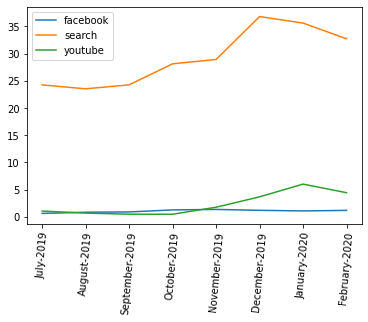

In [398]:
for i in ['facebook','search','youtube']:
    plt.plot(marg_cac.index,marg_cac[i])
plt.xticks(rotation=85)
plt.legend(['facebook','search','youtube'])
plt.show()

In [402]:
y_f=[marg_cac.loc['November-2019']['facebook'],
marg_cac.loc['December-2019']['facebook'],
marg_cac.loc['January-2020']['facebook']]

y_s=x_f=[marg_cac.loc['November-2019']['search'],
marg_cac.loc['December-2019']['search'],
marg_cac.loc['January-2020']['search']]

y_y=[marg_cac.loc['November-2019']['youtube'],
marg_cac.loc['December-2019']['youtube'],
marg_cac.loc['January-2020']['youtube']]


x=['November-2019','December-2019','January-2020']

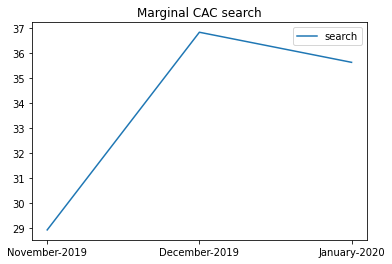

In [406]:
y_s=x_f=[marg_cac.loc['November-2019']['search'],
marg_cac.loc['December-2019']['search'],
marg_cac.loc['January-2020']['search']]


plt.title('Marginal CAC search')
plt.plot(x,y_s)
plt.legend(['search'])
plt.show()

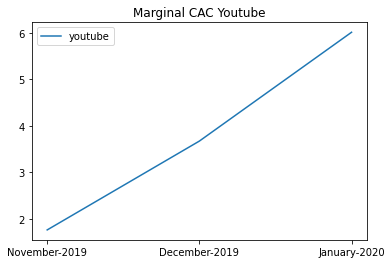

In [407]:
plt.title('Marginal CAC Youtube')
plt.plot(x,y_y)
plt.legend(['youtube'])
plt.show()

In [408]:
y_f=[marg_cac.loc['September-2019']['facebook'],
marg_cac.loc['October-2019']['facebook'],
marg_cac.loc['November-2019']['facebook']]

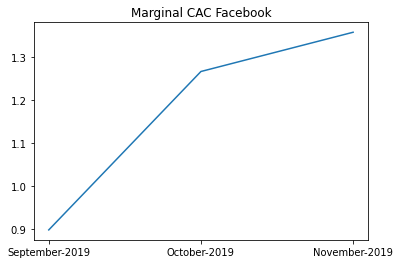

In [409]:
x=['September-2019','October-2019','November-2019']
plt.title('Marginal CAC Facebook')
plt.plot(x,y_f)